#  Analyzing and Predicting Player Count Trends in Online Games

## Part 3: Model Construction

We will be utilizing a model known as SARIMAX, or Seasonal Auto-Regressive Integrated Moving Average with Exogenous Regressors. At first, we will not be using exogenous regressors, but we will be eventually incorporating our 'event' column to assess the impact of an ongoing event to our predictor of choice.  

### Modelling Goals

We wish to predict 3 separate things:

1. Number of players at a given time in the future
2. Player growth over a given period
3. Player growth at a given time.

### Modelling Process for SARIMA and SARIMAX

1. Transform Data
    - Outlier Removal
    - Discontinuity
2. Determine Seasonality
    - Spectral Analysis
3. Stationarity
    - ACF & PACF Analysis
4. Model Construction
5. Model Comparison

### Modelling Process for Our Data

We have to ask what exact model we want to construct. Would we want a model that is built on a single game and can only preedict that one game? Or should we build a model that takes an amalgamization of all games, and build a model based upon that? Or perhaps making a model based upon our control dataframe, Team Fortress 2, and seeing how this model performs on other games. 

1. Basic Modelling
    - CSGO
    - DOTA 2
    - Rocket League
    - Team Fortress 2
2. Amalgamized Modelling
    - Amalgamization Technique
    - Modelling
    - Testing


In [1]:
# we import the necessary libraries

import math
from scipy.stats import boxcox as bc
import scipy.stats
import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

fsds v0.2.30 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


[i] Pandas .iplot() method activated.


## Data Retreival

In [2]:
# we import our dataframes

csgo = pd.read_csv('data/Clean/csgo.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
dota = pd.read_csv('data/Clean/dota.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
rl = pd.read_csv('data/Clean/rl.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
tf = pd.read_csv('data/Clean/tf.csv', parse_dates = ['DateTime'], index_col = 'DateTime')

raw_ls = [csgo, dota, rl, tf]

labels = ['CS:GO', "DOTA 2", 'Rocket League', 'Team Fortress 2']

ls = raw_ls

ls[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2195 entries, 2015-01-01 to 2021-01-03
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2195 non-null   int64  
 1   players       2195 non-null   int64  
 2   viewers       2195 non-null   int64  
 3   event         2195 non-null   float64
 4   %chg_players  2146 non-null   float64
 5   %chg_viewers  1998 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 120.0 KB


In [3]:
# we also need to drop unnecessary columns

ls = list(map(lambda df: df.drop(columns = ['Unnamed: 0']), ls))

In [4]:
ls[0]

players  viewers  event  %chg_players  %chg_viewers
DateTime                                                       
2015-01-01   443188        0    0.0           NaN           NaN
2015-01-02   383943        0    0.0     -0.133679           NaN
2015-01-03   398639        0    0.0      0.038277           NaN
2015-01-04   389040        0    0.0     -0.024079           NaN
2015-01-05   376364        0    0.0     -0.032583           NaN
...             ...      ...    ...           ...           ...
2020-12-30  1056057    77815    0.0      0.021949     -0.075634
2020-12-31   982583    60120    0.0     -0.069574     -0.227398
2021-01-01  1020715    91532    0.0      0.038808      0.522488
2021-01-02  1079804    93678    0.0      0.057890      0.023445
2021-01-03  1067795    94130    0.0     -0.011121      0.004825

[2195 rows x 5 columns]

## 1. Basic Modelling

### a. Preparation

#### Transformations

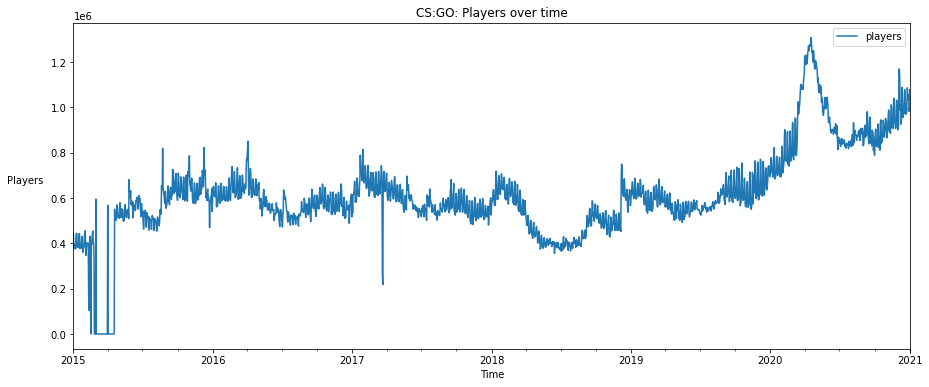

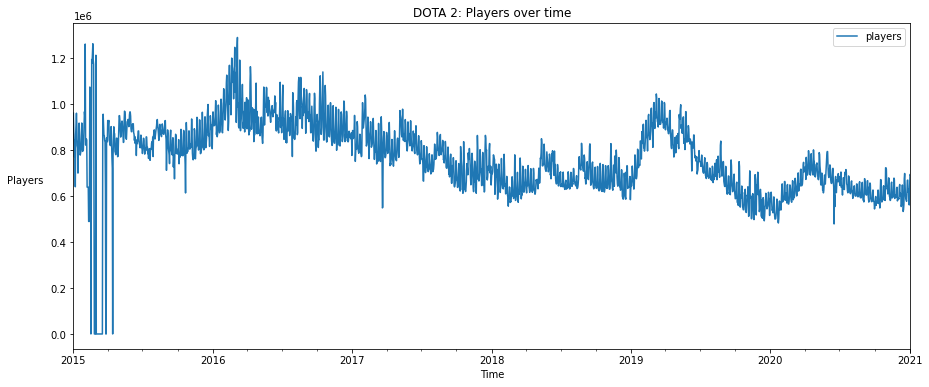

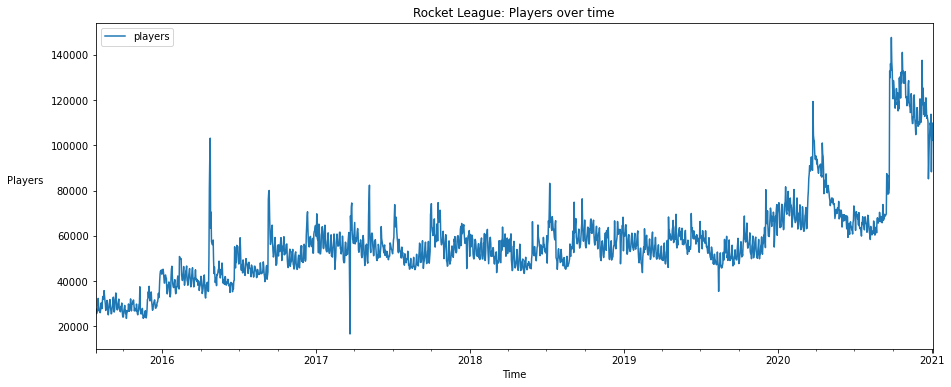

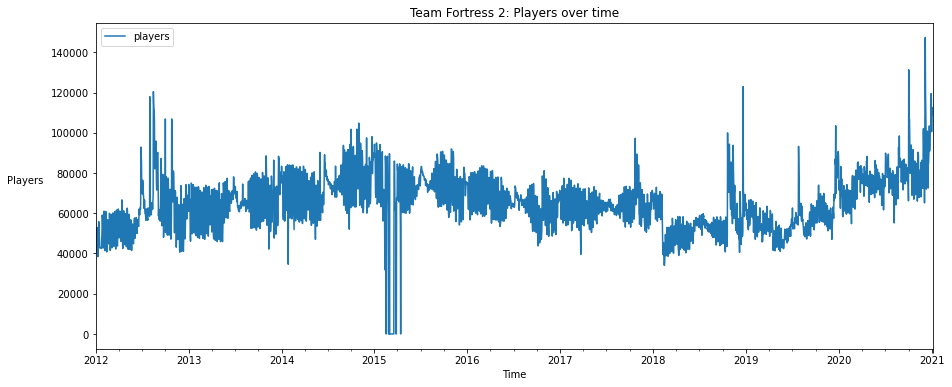

In [5]:
# we need to transform data before we even decide on our predictor column. Let's inspect players over time first. 


for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()
    
    

In [6]:
# we handle discontinuities

for df in ls:
    df['players'] = df['players'].replace(to_replace = 0, method = 'bfill')

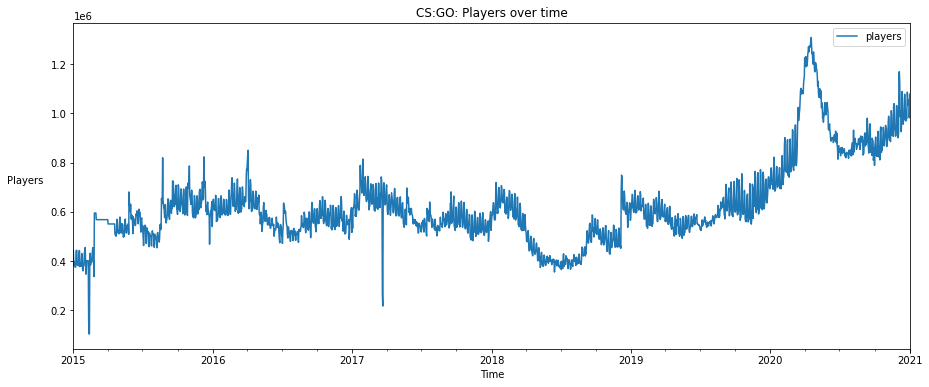

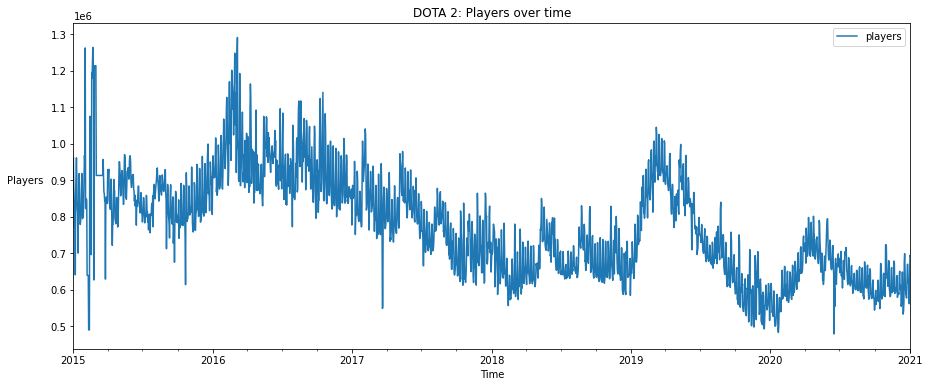

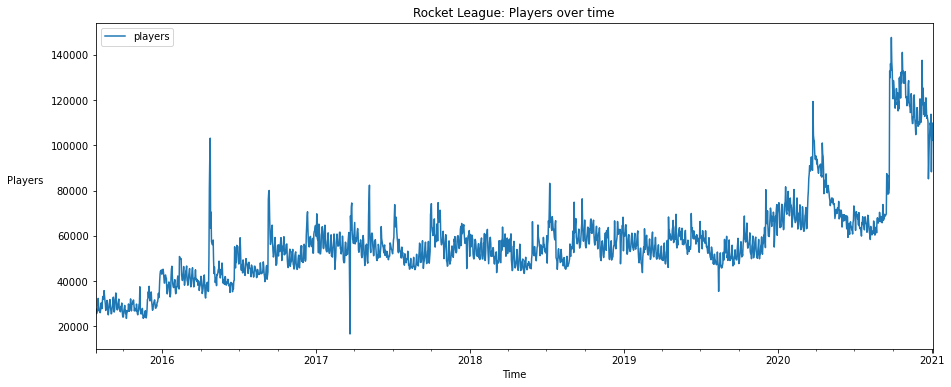

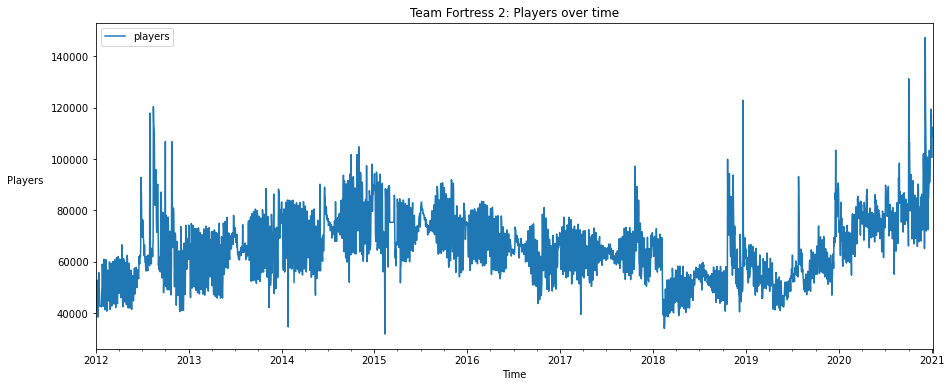

In [7]:
# and inspect to ensure this was successful

for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()

In [8]:
# all of these games had major changes in number of players directly after their release, leading us to 
# model only player data a sufficient time after release. 

start_dates = [ "2016-01-01",
              "2016-01-01",
              "2016-01-01",
              "2013-01-01"]

trimmed_df_list = []

for i in range(0, 4):
    trimmed = ls[i][start_dates[i]:]
    trimmed_df_list.append(trimmed)
    
ls_trimmed = trimmed_df_list
ls = trimmed_df_list    

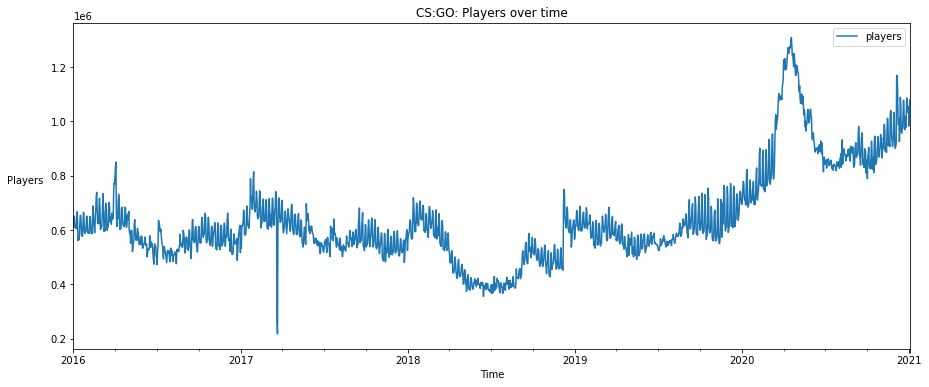

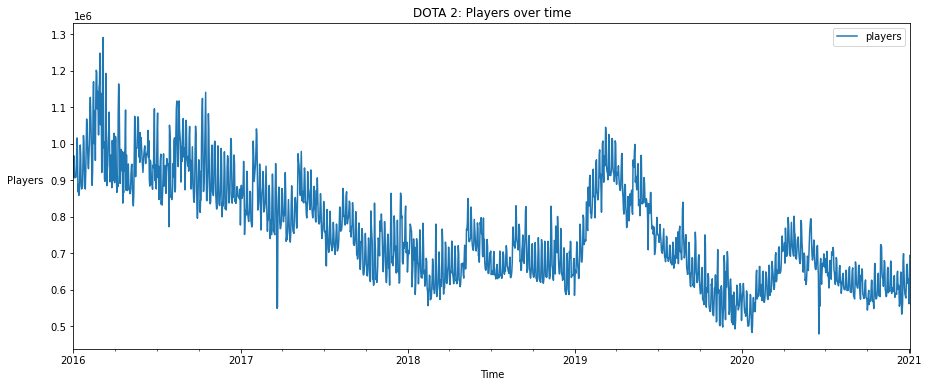

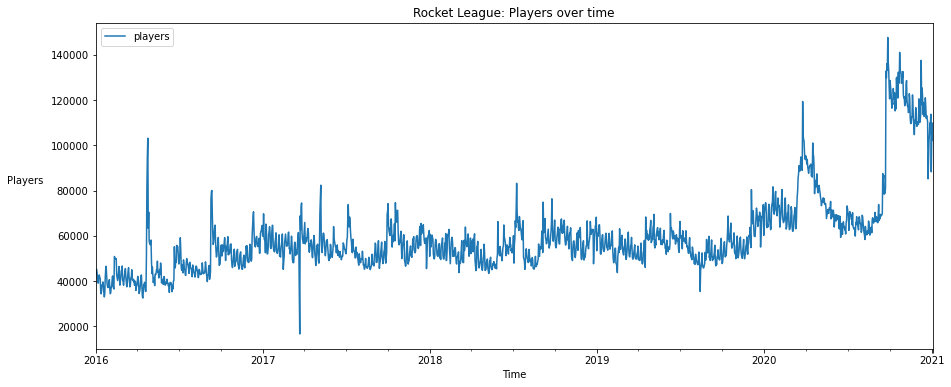

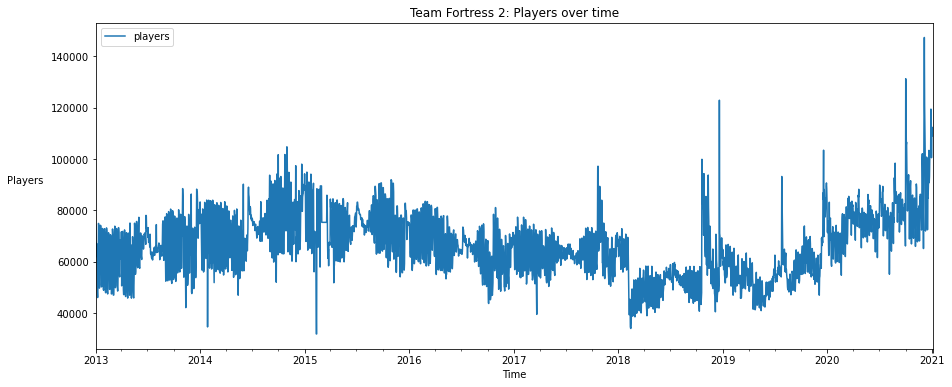

In [9]:
# we inspect our trimmed data

for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()

Looking much better, but we have more work to complete before this can be modelled. 
#### Stationarity

While we can visualize and approximate if our data is stationary or not, we can also complete an AD Fuller test, or Augmented Dickey-Fuller, to give us a metric of stationarity. 

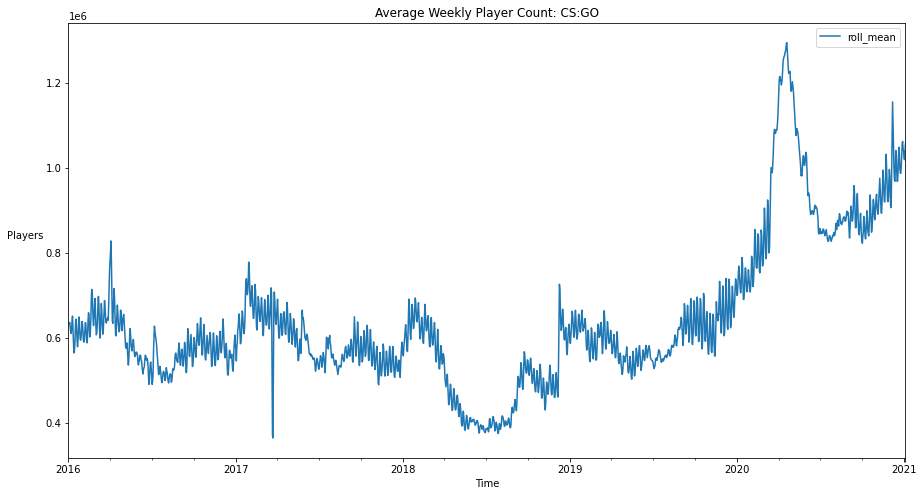

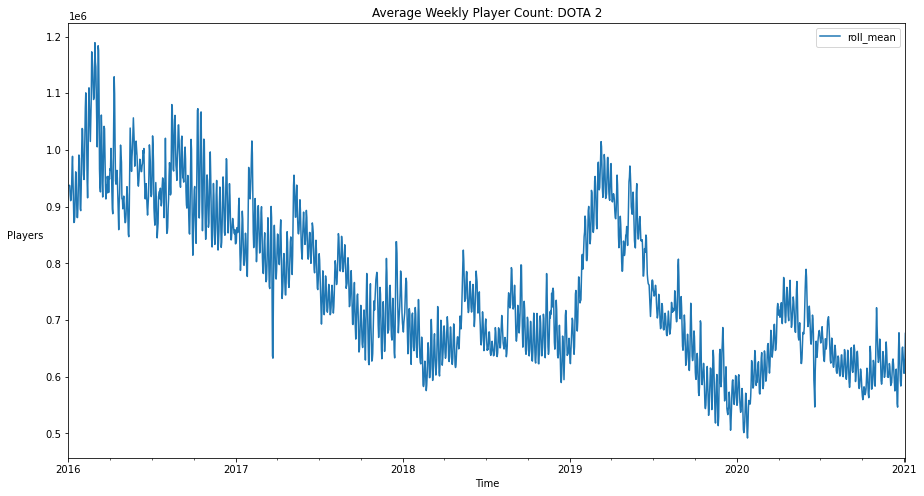

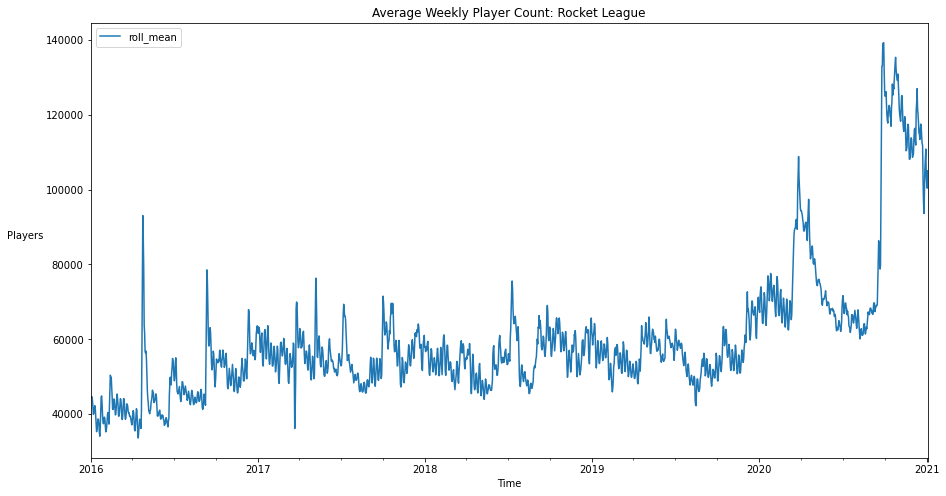

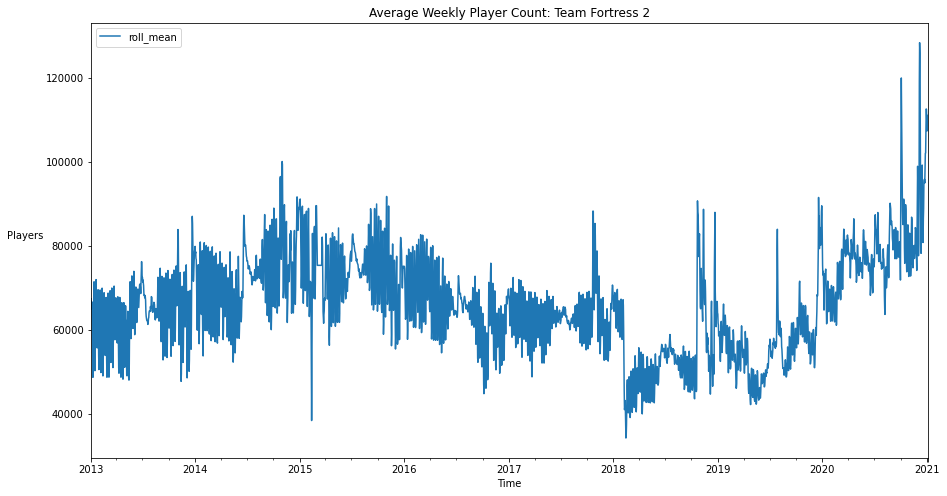

In [10]:
# we visualize our mean player count over time. If this plot has a trend, our data is not stationary. 

for i, df in enumerate(ls):
    
    df['roll_mean'] = df['players'].rolling(window = 3).mean()
    
    df.plot(y = 'roll_mean', title = 'Average Weekly Player Count: '+ labels[i], xlabel = 'Time', figsize = (15, 8))
    plt.ylabel("Players", rotation = 0, labelpad = 20)

In [11]:
# we complete AD Fuller tests for our dataframes. 

for i, df in enumerate(ls):
    result = adfuller(df['players'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -1.100558
p-value: 0.714849
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -1.979913
p-value: 0.295449
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -1.891631
p-value: 0.336009
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -2.268343
p-value: 0.182381
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567



Interestingly, our AD Fuller test shows that Team Fortress 2 data may be stationary. By the above visualization, however, we can see that this is not the case. 

None of our games have stationary data, and we can address this in multiple ways. We can complete data transformations such as log transformations, rolling mean transformations, or differencing.

#### Log Tranformation

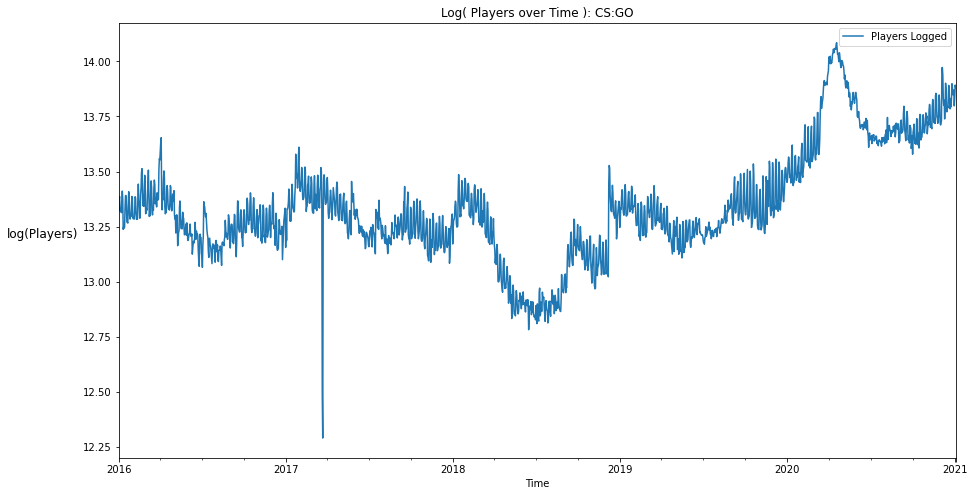

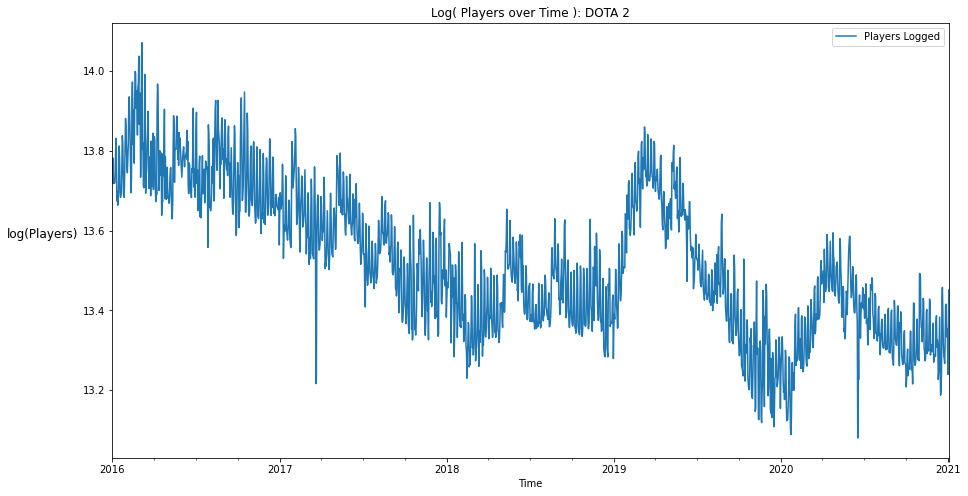

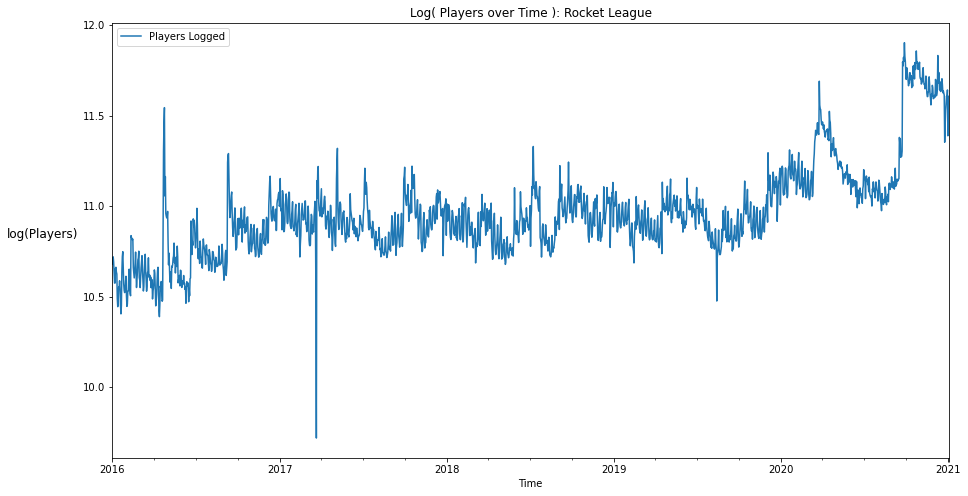

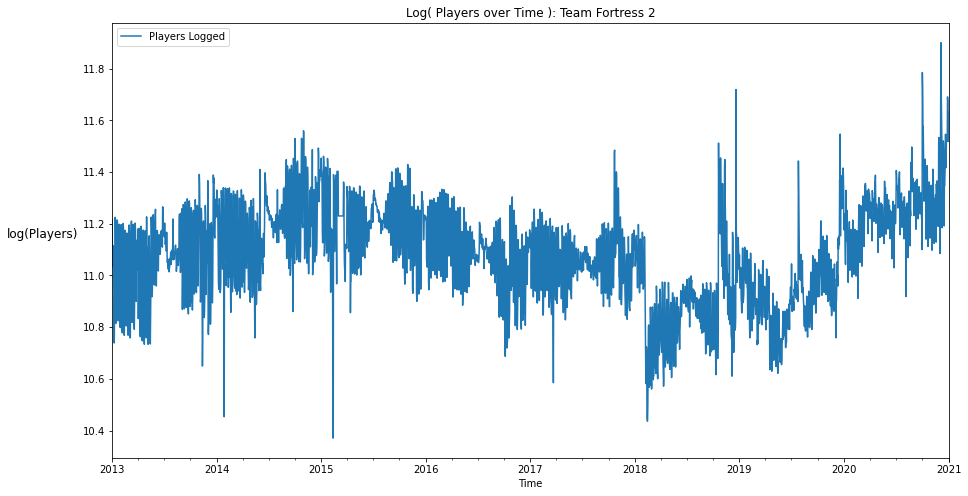

In [12]:
for i, df in enumerate(ls):
    df['players_logged'] = np.log(df['players'])
    
    df.plot(y = 'players_logged', title = 'Log( Players over Time ): '+ labels[i], figsize = (15, 8),
           xlabel = 'Time', label = "Players Logged")
    plt.ylabel('log(Players)', rotation =0 , labelpad = 40, fontsize = 12)
    plt.legend()
    plt.show()

In [13]:
# ADF testing for logged data
for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['players_logged'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -0.904982
p-value: 0.786327
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -2.021767
p-value: 0.277111
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -2.091429
p-value: 0.247975
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -2.264076
p-value: 0.183816
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



#### Rolling Mean Transformations

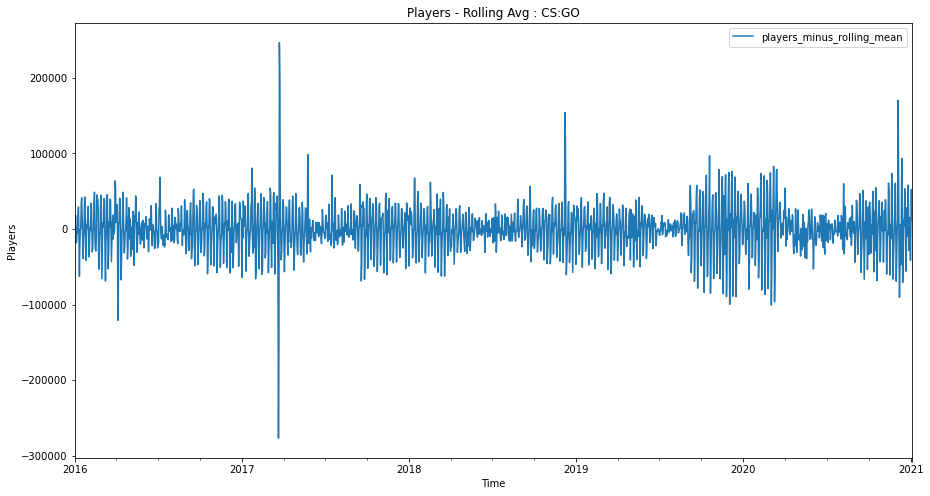

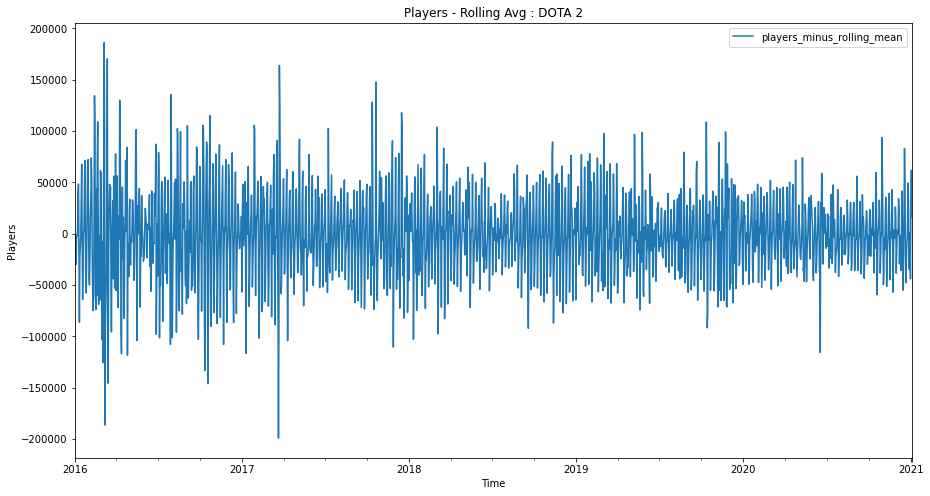

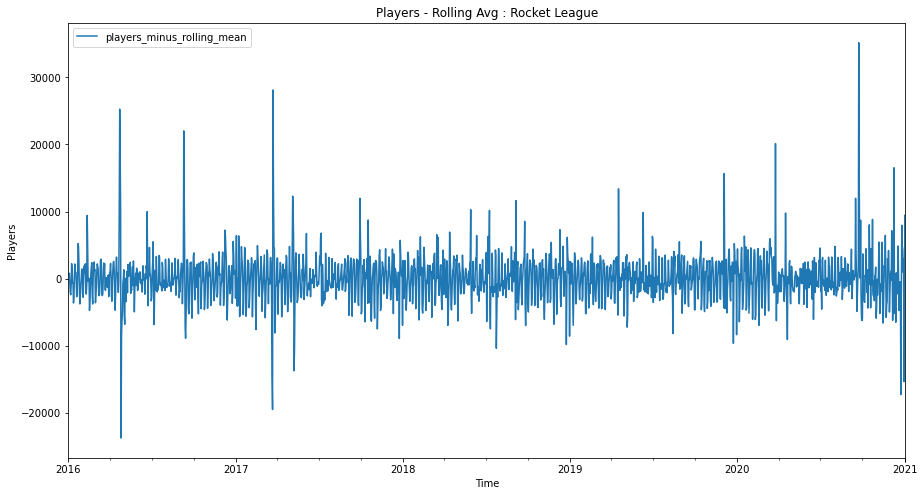

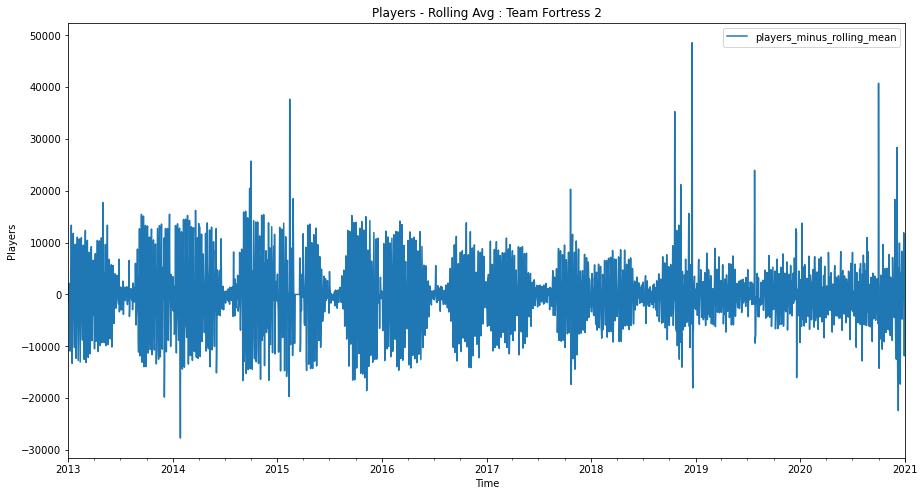

In [14]:
# we can stationize our data by subtracting the rolling mean from our 'players' column. This will force our data to be centered
# on the mean, even if the mean changes over time. 

for i, df in enumerate(ls):
    df['players_minus_rolling_mean'] = df['players'] - df['roll_mean']
    df.plot(y = 'players_minus_rolling_mean', title = "Players - Rolling Avg : "+ labels[i], figsize = (15, 8),
           xlabel = 'Time')
    plt.ylabel('Players')
    plt.show()

In [15]:
# ADF Test for Rolling Mean Transformed data

for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['players_minus_rolling_mean'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -7.717482
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -10.006815
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -10.527083
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -11.862384
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



The data looks beautifully stationary now, though there are severe outliers in some cases. We'll address this after checking how differencing will make our data look.
#### Differencing

We have already constructed a column that represents a differencing technique. Our '%chg_players' represents this difference in the form of a percentage, but let's construct the raw difference for each games player counts. 

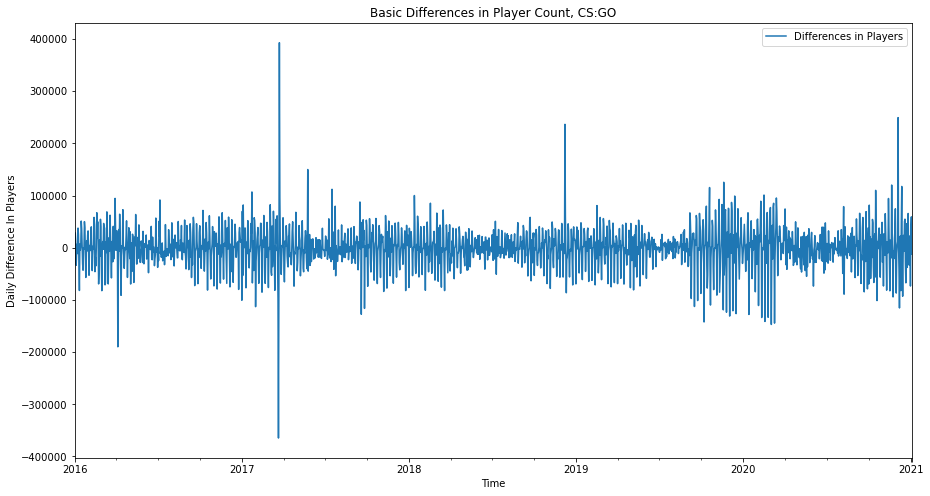

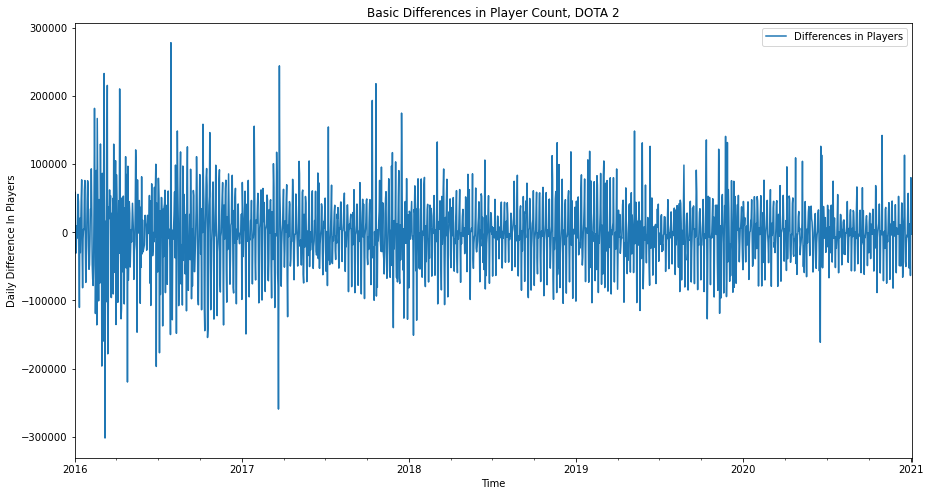

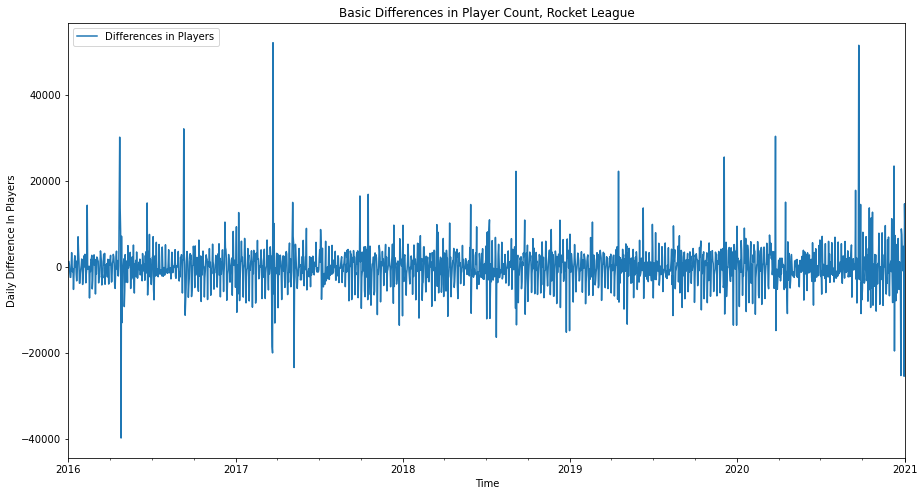

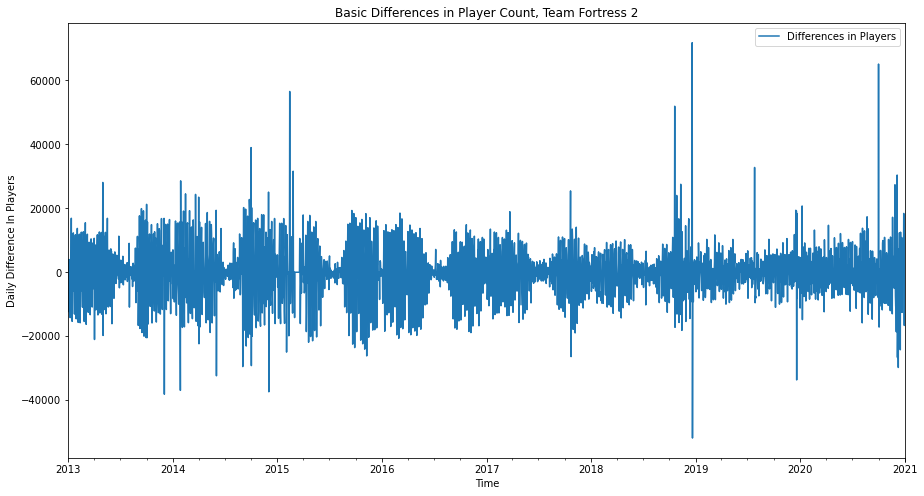

In [16]:
# basic differences

for i, df in enumerate(ls):
    df['difference'] = df['players'].diff(periods = 1)

    df.plot(y = 'difference', title = "Basic Differences in Player Count, "+ labels[i],
            label = 'Differences in Players', figsize = (15, 8), xlabel = 'Time', 
            ylabel = "Daily Difference In Players")
    plt.legend()
    plt.show()

In [17]:


for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['difference'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -8.654211
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -10.874767
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -10.934633
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -12.070897
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



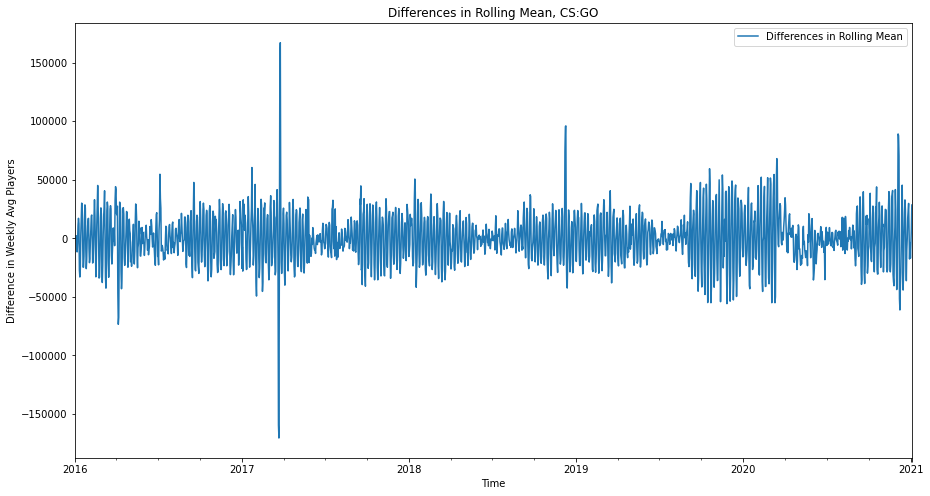

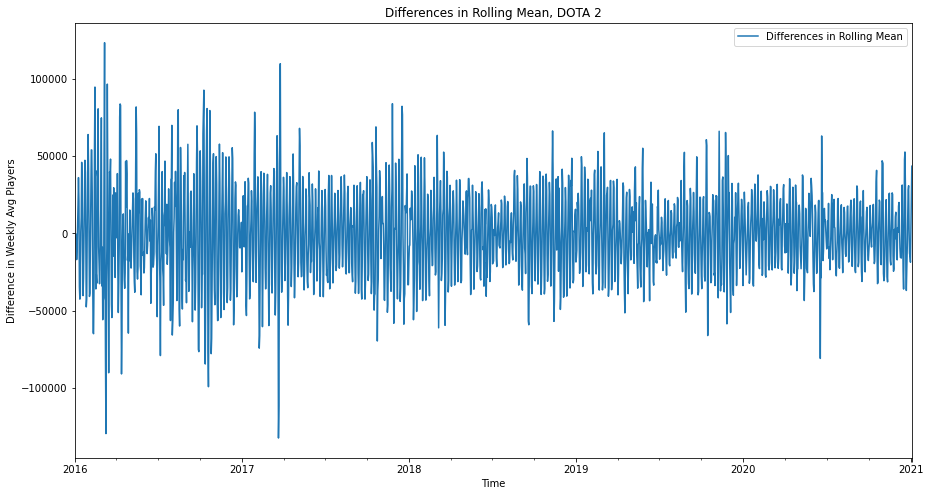

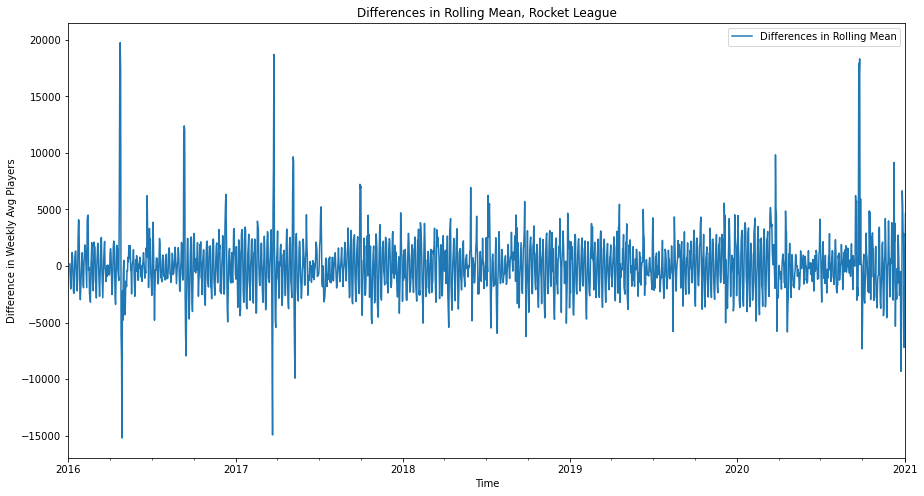

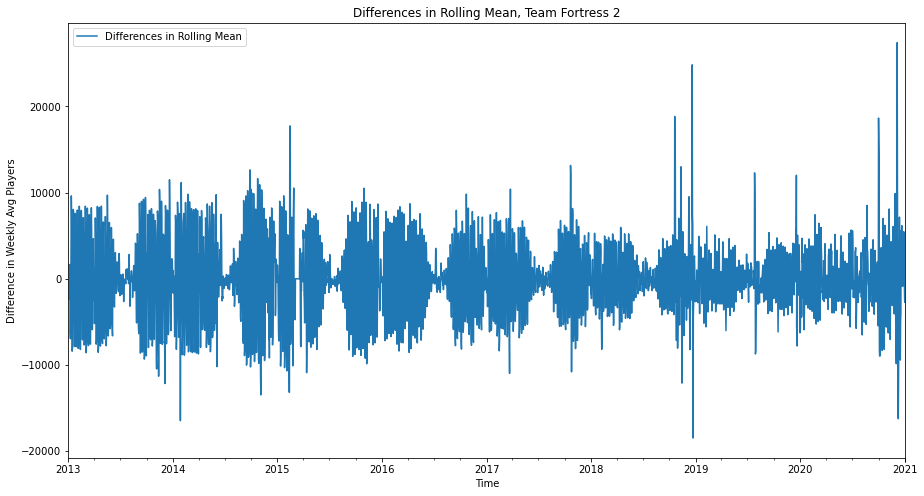

In [18]:
# differences of the rolling mean, though this would affect model interpretability

for i, df in enumerate(ls):
    df['rolling_mean_diff'] = df['roll_mean'].diff(periods = 1)
    
    df.plot(y = 'rolling_mean_diff', xlabel = 'Time', ylabel = 'Difference in Weekly Avg Players', label = 'Differences in Rolling Mean', figsize = (15,8),
           title = 'Differences in Rolling Mean, '+ labels[i])
    plt.legend()
    plt.show()


In [19]:
for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['rolling_mean_diff'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -6.669552
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -9.070268
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -9.100540
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -10.318498
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



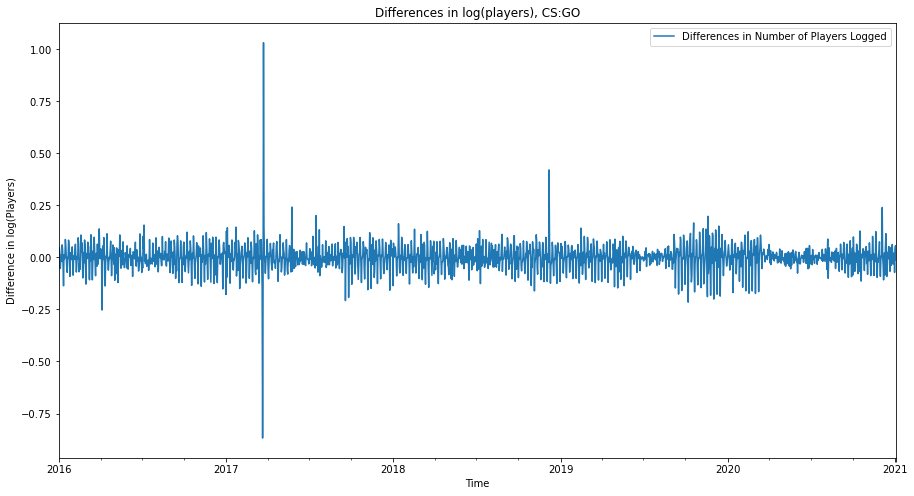

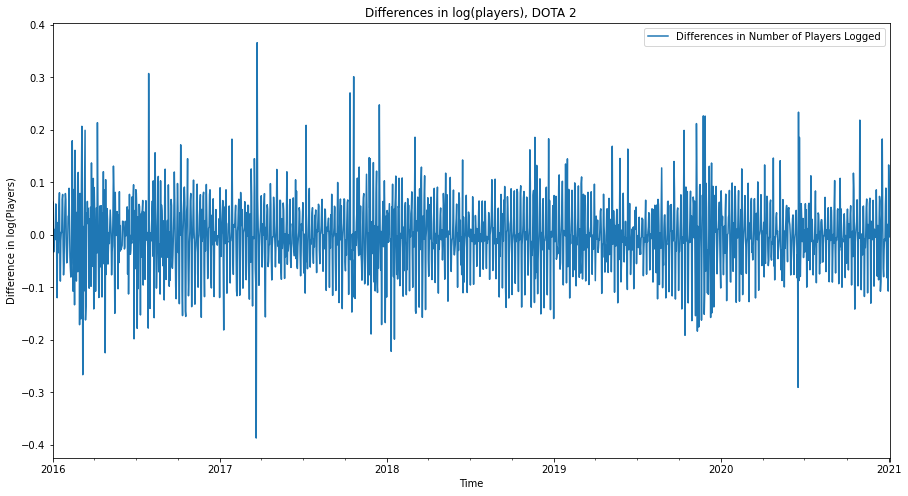

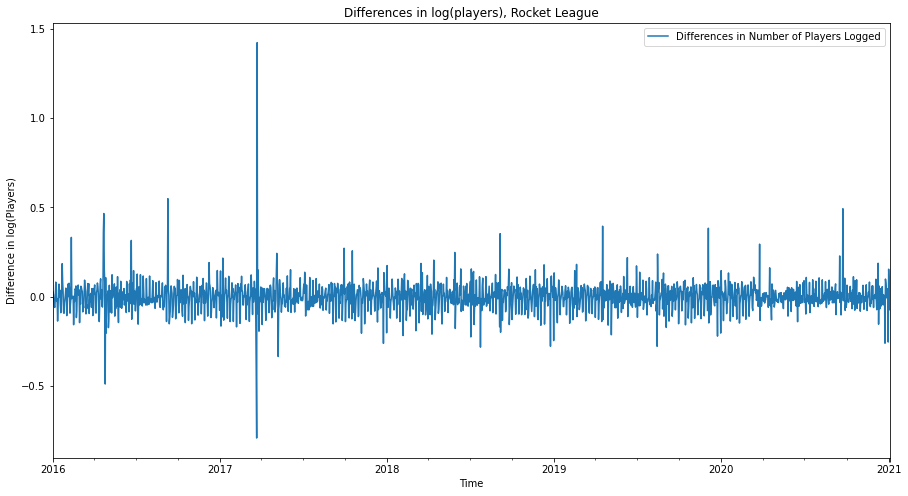

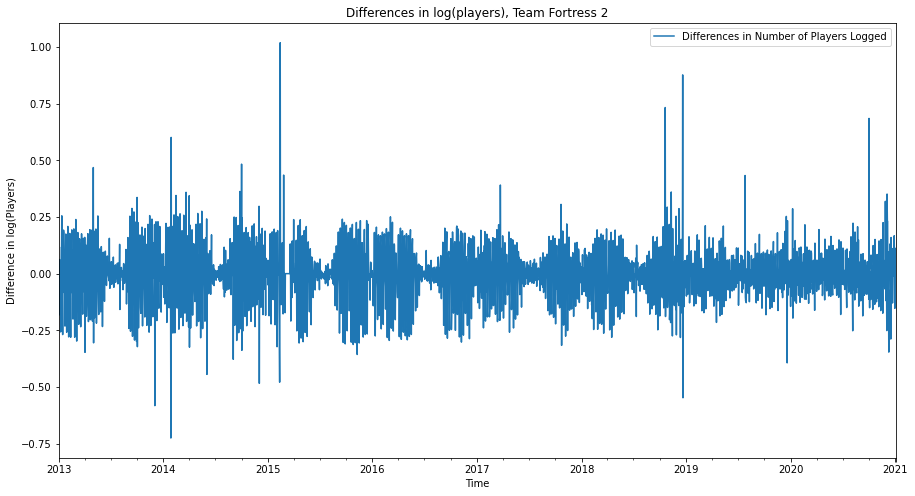

In [20]:
# differences in logged data

for i, df in enumerate(ls):
    df['players_logged_diff'] = df['players_logged'].diff(periods = 1)
    df.plot(y = 'players_logged_diff', title = 'Differences in log(players), '+labels[i], label = 'Differences in Number of Players Logged', figsize = (15, 8),
           xlabel = 'Time', ylabel = 'Difference in log(Players)')

In [21]:
for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['players_logged_diff'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -10.157618
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -9.980158
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -11.476221
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -11.784883
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



Great! Our visualizations suggest well stationized data, and we verified this through our ADF testing. We are ready to prepare our data for modelling through outlier removal, the final step. 

#### Outliers

We are going to deal with extreme outliers only, and we will continue on with using Logged Data, as this is normalized, on a small scale, and easily transformed back to player count.

In [22]:
# we need to keep a list of dataframes with outliers to use as a testing space.

ls_w_outliers = ls

In [23]:
ls = list(map(lambda df: df.dropna(), ls))

In [24]:
# outliers for our 'players_logged_differences'

# we replace outliers with the preceding non-outlier value

plotting_lists = []

for df in ls:
    outlier_removed = []
    Inter_qr = scipy.stats.iqr(df['players_logged_diff'])
    mean = df['players_logged_diff'].mean()
    Q1 = df['players_logged_diff'].quantile([0.25])[0.25]
    Q3 = df['players_logged_diff'].quantile([0.75])[0.75]
    upper = Q3 + 3*Inter_qr
    lower = Q1 - 3*Inter_qr
    print(lower, upper)
    for i, val in enumerate(df['players_logged_diff']):
        if val > upper:
            df['players_logged_diff'][i] = df['players_logged_diff'][i-1]
        elif val < lower:
            df['players_logged_diff'][i] = df['players_logged_diff'][i-1]
        else:
            continue


-0.19719134797564752 0.2014688531098061
-0.254719751483802 0.2648006319631122
-0.26011755209674803 0.2665679191113206
-0.32827209527797674 0.3356595500556514


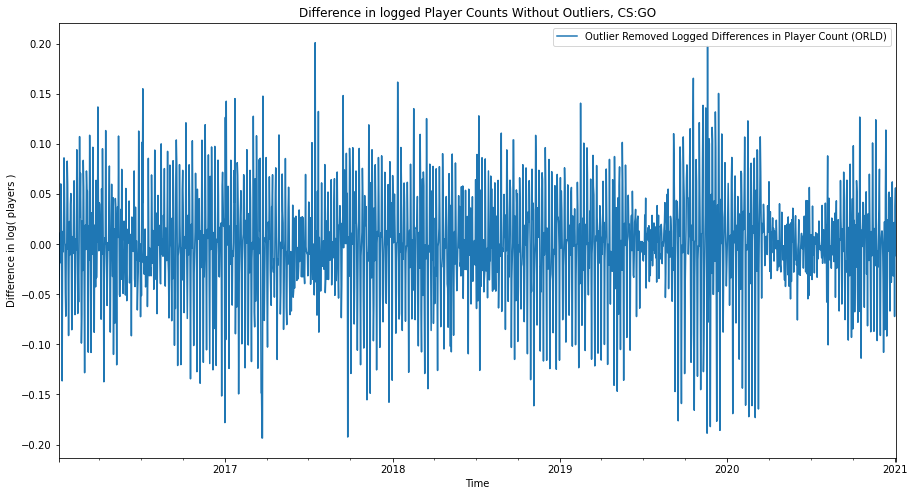

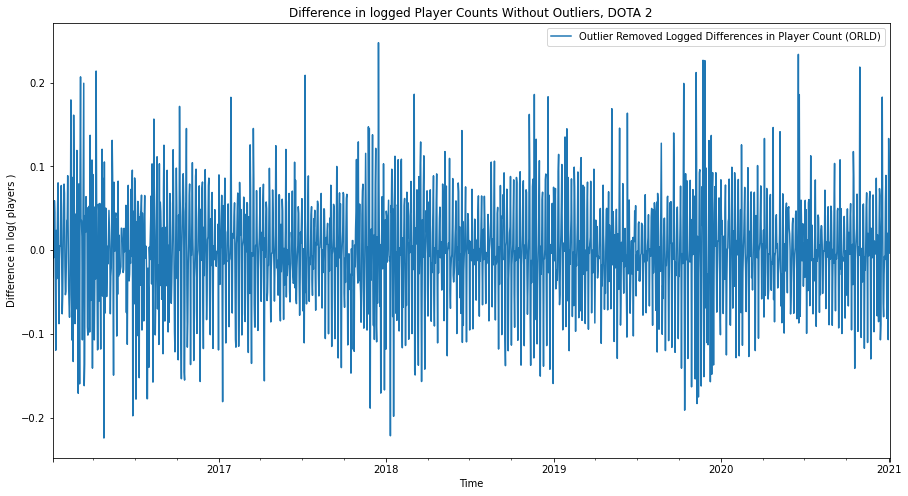

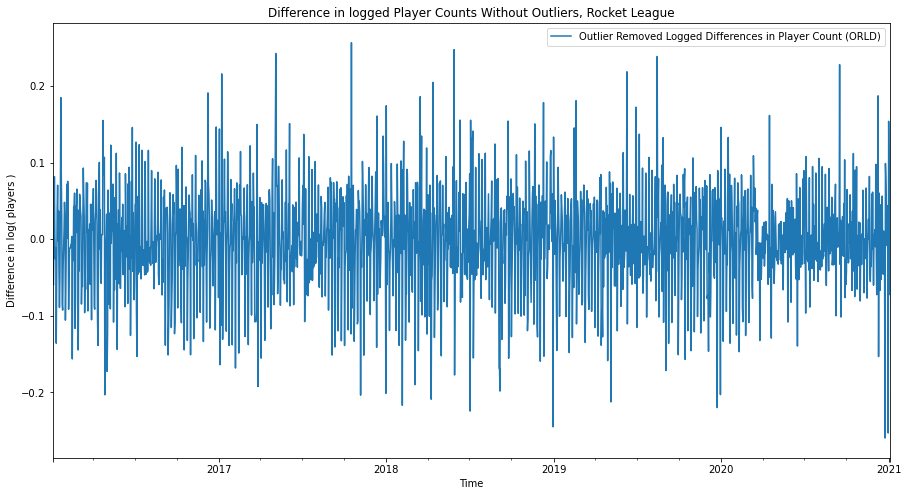

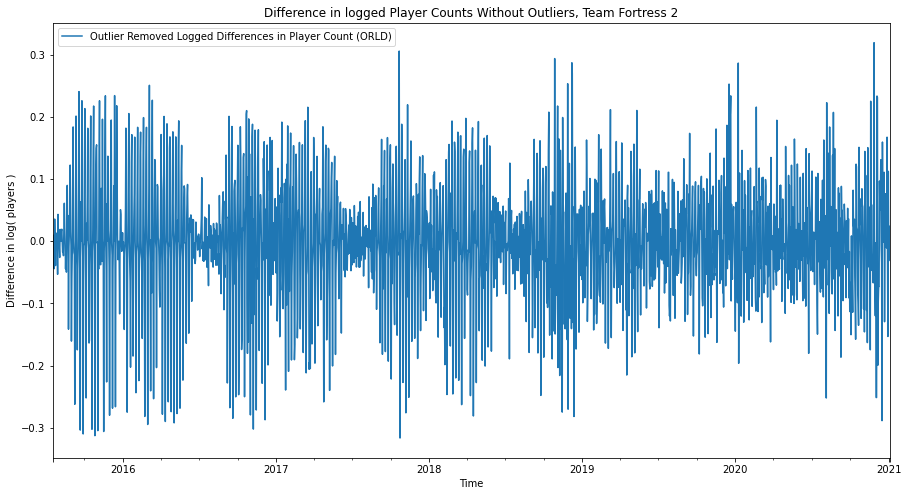

In [25]:
# let's see how this affected our data

for i, df in enumerate(ls):
    
    df.plot(y='players_logged_diff',label = "Outlier Removed Logged Differences in Player Count (ORLD)", figsize = (15, 8),
           xlabel = 'Time', ylabel = "Difference in log( players )", title = "Difference in logged Player Counts Without Outliers, "+ labels[i])
    plt.legend()
    plt.show()

We have beautifully stationary data, without outliers, and this is also very easy to return to our original player count!

This data is ready to be modelled. 

In [26]:
ls_prepped = ls

### b. Model Construction

We will be using a gridsearch to find the optimal model. However, we still have to manually find S, or the seasonal component of the model. 

In [27]:
# we define our predictor column and prepare it.

mod_ls = []

for df in ls_prepped:
    df_mod = pd.DataFrame()
    df_mod['ORLD'] = df['players_logged_diff']
    mod_ls.append(df_mod)
    
training_ls = mod_ls

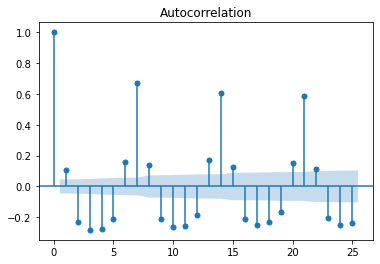

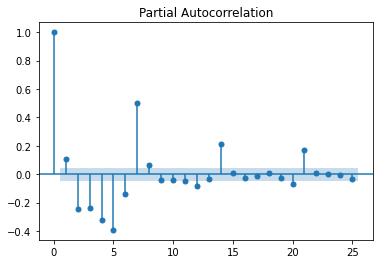

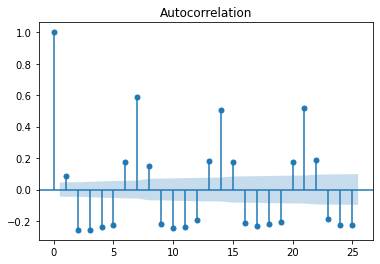

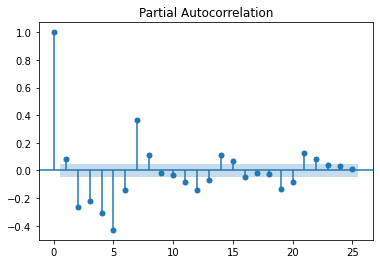

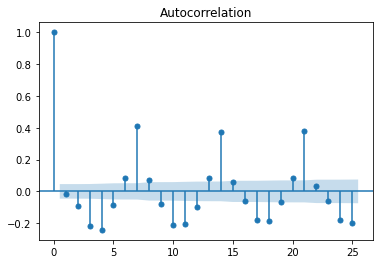

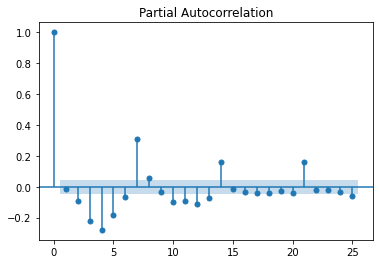

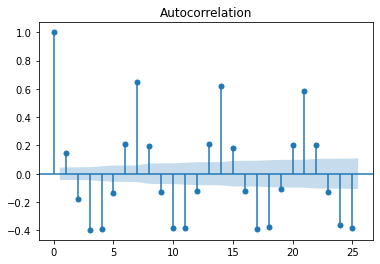

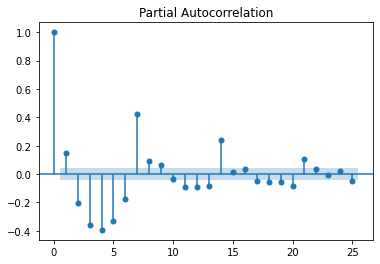

In [28]:
# we plot both ACF and PACF

for df in mod_ls:
    acf = plot_acf(df, lags = 25)
    pacf = plot_pacf(df, lags = 25)

The above plots suggest that our seasonal period for all our games is 7 days, or one week. 

In [29]:
# we establish our parameter variables

p = d = q = range(0, 2)

pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]




In [30]:
# performing the gridsearch


ans_ls = []
for df in mod_ls:
    df = df.dropna()
    ans = []
    for comb in pdq:
        for combs in pdqs:
            mod = SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df = ans_df.loc[ans_df['aic'].idxmin()].dropna()
    
    ans_ls.append(ans_df)


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5412.14552460485
ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-6011.408284666195


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6157.1366785778355
ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6707.083501236342
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6481.827497667089


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6771.65736597479
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6454.6105908496675


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6712.545134650534
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5442.985776806138


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-6008.41280366574


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6181.058967741697


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6715.859024991187


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6493.34749475932


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6778.110537154882


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6480.458662973964


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6721.346172144397
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4354.783496208123


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4809.869761911355


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4688.440452275536


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5337.584823212175


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5107.1896414936655


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5391.551845580235


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5002.458613328386


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5346.830491445244


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5395.501950217673


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5995.040357315762


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6139.509627493833


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6691.459853972779


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6467.757664506995


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6752.295829427028
ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6440.545672980569


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6696.001074713326
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5432.191791716542


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-6010.920724683112
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6181.275547545603


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6714.700185959415


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6492.079831254158


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6779.618301531487


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6472.77087573123


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6719.839004085179


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5540.093243270474


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-6140.997184361272
ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6345.585163507535


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6777.978892043604


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6613.441541166476


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6844.723590913964


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6584.379276797023


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6789.110795701766
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4534.841789318491


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5114.57317954714


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5283.279301658406
ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5804.240781606335


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5593.268999978377


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5865.207628357491


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5567.2654083588695
ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5808.421660937912


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-5415.4924321825965


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5994.58269486039


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-6163.279856989709
ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6698.86413407498


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-6478.007033853898


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6760.121344210564


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-6461.972854367132


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6702.799777899829
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4796.382186622223


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5256.522838672336
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5136.479722235471


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5987.897980119986
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5550.476148472426


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6012.332884648821
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5434.033770267652


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6028.1981231758655
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4815.20563865051


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5251.654619991591
ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5218.871543804942

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6056.08876259589


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5591.1863852215365


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6080.393117589618


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5524.076405284421


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6102.276010347439
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3689.8098354910862


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3980.1173189863634


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3554.8623675643985


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4452.465018845184
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4115.58513226393


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4471.883590746913
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3856.8685044110534


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4479.764978844997


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4780.4467233918


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5241.29426060848


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5119.704446608188


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5966.722388574631


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5536.946228607136


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5989.841010557346


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5420.532034114216


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6004.6103885243565
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4807.594504845085


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-5255.0802411451805
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5202.08061928427


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-6035.8246400654825


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5576.823449651132


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-6060.400272298357


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5495.6310835322165


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-6081.9073627384405


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4982.400638611289


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5456.975196944642
ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5410.613371742055


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6125.737116215709


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5753.593296146693


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6149.533696604743


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5649.115476632898


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6167.665329860807
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3876.670481479713


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4303.110950360866


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4193.984891755679
ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5019.897989416771


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4591.997682374489


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5040.865212237699


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4476.851317479406


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5067.438963917428


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4791.649013616576


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5239.82074108177


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-5184.95430966675


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-6014.681516959427


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5563.266487714753


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-6037.868191306183


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5482.700808781344


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-6057.865649438912
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4754.132015857273


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4956.800412902802
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4459.866703657828


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5306.204456275844
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5079.708360905179


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5354.034714082076
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4897.231798074956


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5307.248011808324
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4749.889485264719


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4963.837331834375
ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4501.904681805476


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5326.962637222929


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5099.067400913562


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5378.827702602119


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4934.295143768206


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5329.320570160733
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3457.2529115840534


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3589.3755687303187
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2936.8712319618844


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-3863.6511985106304
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3656.551427359753


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-3893.3453572568797
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3397.962260641637

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-3869.1209220278106


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4738.636765746904


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4942.486189160511


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4445.699141573904


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5287.836853208644


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5066.605933525152


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5335.691343714492


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4884.026047892747


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5287.911748722941
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4752.596645440336


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4962.392272874629
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4501.854426762988


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5327.397474886389


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5092.606708467225


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5377.924477855562


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4928.542256172412


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5328.226389562415


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4858.248080028778


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-5070.190682174096
ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4500.1676727719405


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5368.732218448104


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5196.525815035902


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5388.664766522862


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5043.085076183347


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5378.8952899897195
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3895.014285611406


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4101.042174899483
ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3621.21625816012


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4434.209455590364


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4224.581706538147


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4484.957000183936


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4062.838380274872


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4437.001774049188


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-4737.118139117238


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4947.956952096012


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4487.333658914484


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5309.115975209279


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-5079.523010917514


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5359.452297501177


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4915.856742620141


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5308.892451132891
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3707.3466550307103


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4275.347201286934
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4405.831769404199


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5154.493248440356
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4785.424237157192


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5201.169056732714
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4853.529440269402

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5159.228879623227
ARIMA (0, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-3760.2786989018477


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4274.2582685016405
ARIMA (0, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4472.123667186759

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5186.737327329979


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4812.6290860737645


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5233.8457927202135


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4908.9380313493475


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5189.035804350055
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2635.3398933253693


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-2993.7172906535584
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2730.972371662041


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-3582.754972827812
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3264.3192815398215


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-3621.59563034301
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3216.063656919424


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-3601.5152620695967


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-3692.9290364297512


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4261.15220586531


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4390.861438646509


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5137.686336487307


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4772.456847188664


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5183.111153199121


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4840.491400292538


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5139.952583868973
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3748.2100561158786


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)12 : AIC Calculated =-4276.214434826926
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4454.594439822288


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)12 : AIC Calculated =-5177.278768245825


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4799.789229659353


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)12 : AIC Calculated =-5224.445457228405


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4887.517886250642


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)12 : AIC Calculated =-5179.6070016009835
ARIMA (1, 0, 1) x (0, 0, 0, 7)12 : AIC Calculated =-3870.129690410991


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4463.284970374296


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4671.710514089907


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5261.83883182819


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4981.298789115251


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5309.857002957142


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)12 : AIC Calculated =-5025.198996760834


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5287.539745934984
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2837.0728664110893


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)12 : AIC Calculated =-3318.198544640722
ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3347.2258982506382


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 1, 7)12 : AIC Calculated =-4095.815581936542


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3748.514260226326
ARIMA (1, 1, 0) x (1, 0, 1, 7)12 : AIC Calculated =-4141.360754478722


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3787.126229206935


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 1, 7)12 : AIC Calculated =-4102.949902661247


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)12 : AIC Calculated =-3733.699213244373


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)12 : AIC Calculated =-4261.99390069579
ARIMA (1, 1, 1) x (0, 1, 0, 7)12 : AIC Calculated =-4439.473180670735


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)12 : AIC Calculated =-5160.543705147819


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)12 : AIC Calculated =-4786.810720633899


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)12 : AIC Calculated =-5206.432858667942


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)12 : AIC Calculated =-4874.968629892535


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)12 : AIC Calculated =-5161.277085773414



### c. Model Validation

In [64]:
# we generate validation statistics for our models

csgo_model = SARIMAX(mod_ls[0],
                    order = ans_ls[0].loc['pdq'],
                    seasonal_order = ans_ls[0].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
csgo_output = csgo_model.fit()
(csgo_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ORLD   No. Observations:                 1827
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                3427.362
Date:                           Tue, 26 Jan 2021   AIC                          -6844.724
Time:                                   16:36:22   BIC                          -6817.196
Sample:                               01-04-2016   HQIC                         -6834.567
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8101      0.023     35.140      0.000       0.765       0.855
ma.L1         -0.9399      0.016    -59.578      0.000      -0.971      -0.909
ar.S.L7        0.9393      0.009    106.338      0.000       0.922       0.957
ma.S.L7       -0.5786      0.018    -33.008      0.000      -0.613      -0.544
sigma2         0.0013   2.62e-05     51.366      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1597.11
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
dota_model = SARIMAX(mod_ls[1],
                    order = ans_ls[1].loc['pdq'],
                    seasonal_order = ans_ls[1].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
dota_output = dota_model.fit()
print(dota_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                              ORLD   No. Observations:                 1827
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                3088.833
Date:                           Tue, 26 Jan 2021   AIC                          -6167.665
Time:                                   16:36:25   BIC                          -6140.157
Sample:                               01-04-2016   HQIC                         -6157.514
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5832      0.033     17.744      0.000       0.519       0.648
ma.L1         -0.8209      0.025    -33.468

In [66]:
rl_model = SARIMAX(mod_ls[2],
                    order = ans_ls[2].loc['pdq'],
                    seasonal_order = (1,1,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
rl_output = rl_model.fit()
print(rl_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                              ORLD   No. Observations:                 1827
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                2694.448
Date:                           Tue, 26 Jan 2021   AIC                          -5378.895
Time:                                   16:36:27   BIC                          -5351.387
Sample:                               01-04-2016   HQIC                         -5368.744
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7683      0.027     28.565      0.000       0.716       0.821
ma.L1         -0.9110      0.021    -44.322

In [67]:
tf_model = SARIMAX(mod_ls[3],
                    order = ans_ls[3].loc['pdq'],
                    seasonal_order = ans_ls[3].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
tf_output = tf_model.fit()
print(tf_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                              ORLD   No. Observations:                 1998
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                2659.929
Date:                           Tue, 26 Jan 2021   AIC                          -5309.857
Time:                                   16:36:28   BIC                          -5281.880
Sample:                               07-17-2015   HQIC                         -5299.582
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6067      0.037     16.505      0.000       0.535       0.679
ma.L1         -0.8031      0.028    -28.975

In [68]:
models = []
outputs = []
models = [csgo_model, dota_model, rl_model, tf_model]
outputs = [csgo_output, dota_output, rl_output, tf_output]

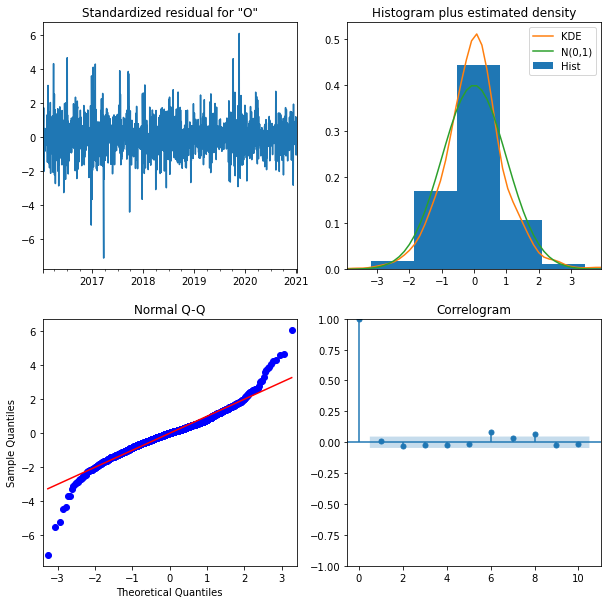

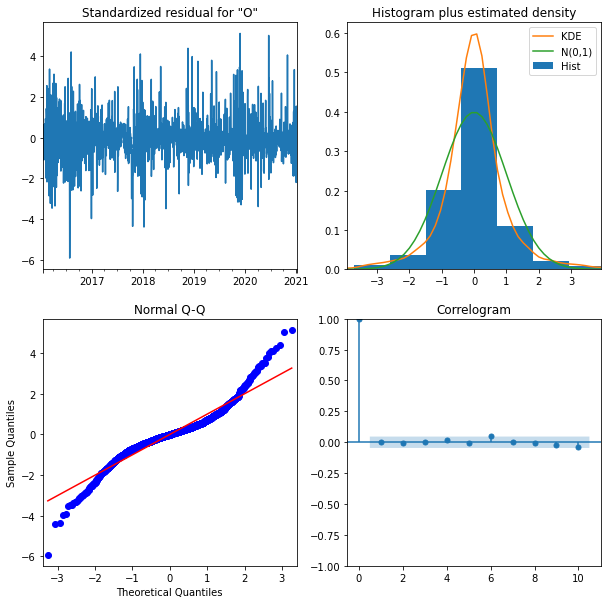

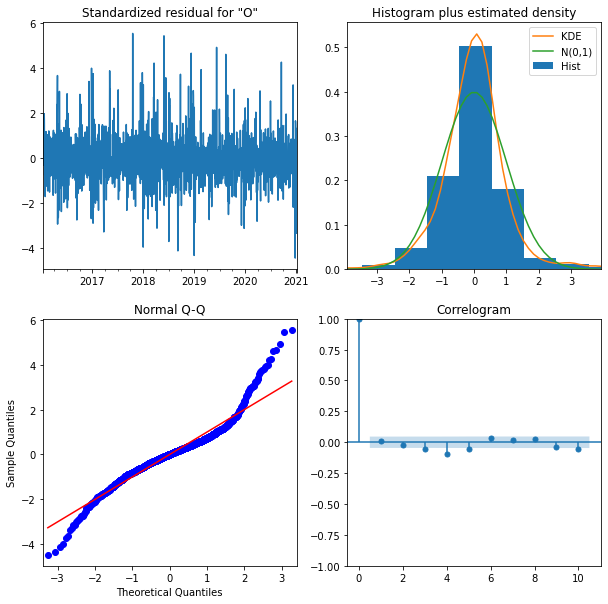

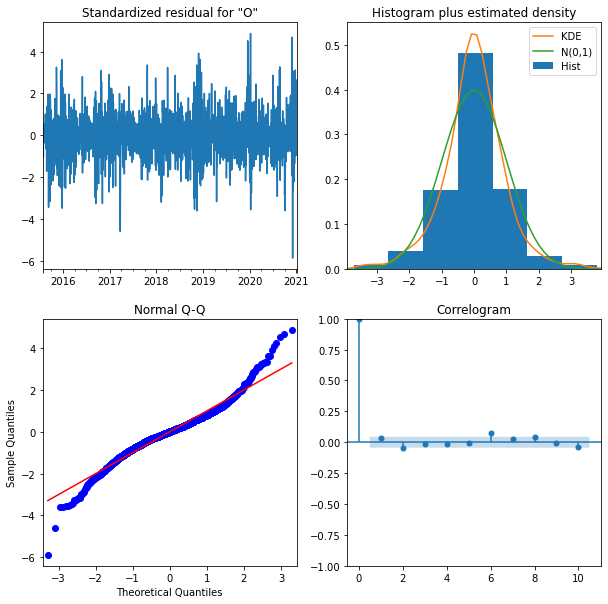

In [36]:
for i, output in enumerate(outputs):
    
    output.plot_diagnostics(figsize = (10, 10))
    

#### Forecasting our Basic Models

We will be forecasting from 2020-12-01 to present, and visualizing the full month.

In [37]:
# we generate our forecasts for each model

predictions = list(map(lambda output: output.get_prediction(start = pd.to_datetime("2020-12-15"), dynamic = False), outputs))
intervals = list(map(lambda prediction: prediction.conf_int(), predictions))

forecasts = list(map(lambda prediction:prediction.predicted_mean.to_frame('predicted_mean'), predictions))


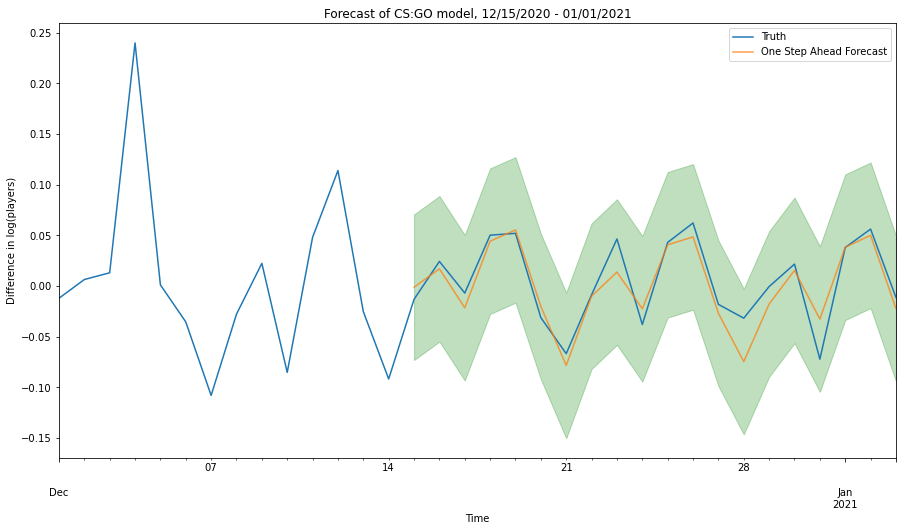

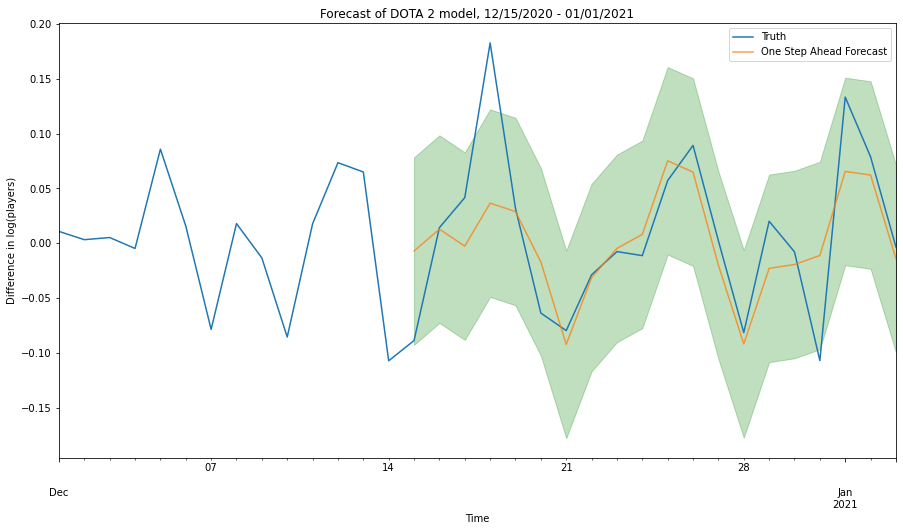

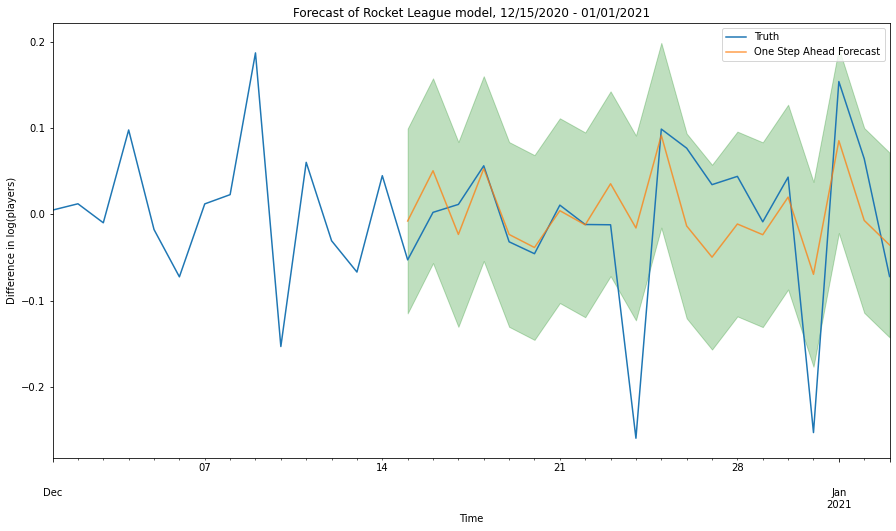

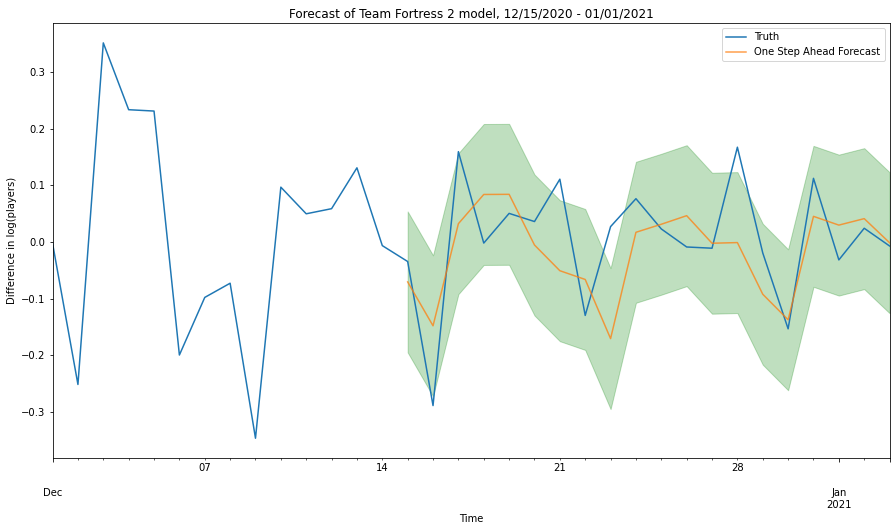

In [38]:

for i, df in enumerate(ls_w_outliers):
    
    ax = df['2020-12-01':].plot(y = 'players_logged_diff', label = 'Truth', figsize = (15, 8),
                               xlabel = "Time", ylabel = "Difference in log(players)",
                               title = 'Forecast of '+ labels[i]+ ' model, 12/15/2020 - 01/01/2021')
    ax.plot(forecasts[i], label = "One Step Ahead Forecast", alpha = 0.75)
    
    ax.fill_between(intervals[i].index,
                   intervals[i].iloc[:,0],
                   intervals[i].iloc[:,1], color = 'g', alpha = 0.25)
    
    plt.legend()
    plt.show()
    

In [39]:
for i in range(0, 4):
    forecasted = predictions[i].predicted_mean
    truth = ls_w_outliers[i]["2020-01-01":]['players_logged_diff']
    error = forecasted - truth
    mse = (error ** 2).mean()
    print(mse)

0.0003091945936490926
0.0025184009562789966
0.006579269286247748
0.008287446484142539


### Part 1 Conclusions:

We constructed 4 models from the dataframes we have, and summary statistics show that these can all be said to be viable models in predicting the logged differences in player counts. P-values are lower than 0.05, and mean squared error values are also very low, though this is without any support until we can compare these values to those of other models. 

## Part 2: Amalgamized Modelling

The goal in this section of our project is to construct a model from all of our dataframes available. We will hopefully gain a model that is able to predict  for all of our games to an accuracy comparable to the accuracy values gained for individual models, found in part 1 above. 

We can construct this model by simply taking the average of all of our dataframe values. In this case we would be forced to scale all values, so we could feasibly use our % change feature for this process.  

### Taking mean values of dataframes
We are going to be taking the mean of '%_chg_players', but we have to prepare this data first. 
### Preparation

In [40]:
# resetting our dataframes to start fresh from when we trimmed the dataframe dates. 

ls = trimmed_df_list

ls = list(map(lambda df: df.dropna(), ls))

In [41]:
# in order to take the mean, we have to have all our series begin at the same time. We only have to alter team fortress 2

ls[3] = ls[3]["2016-01-01":]

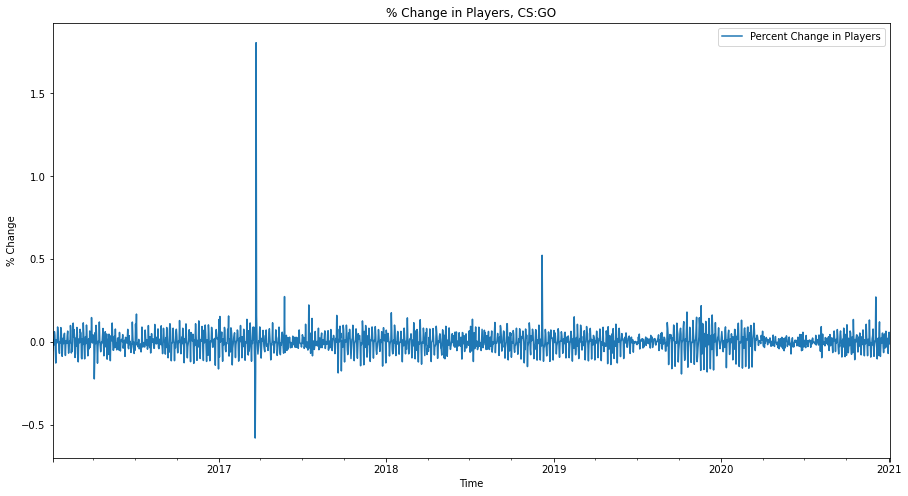

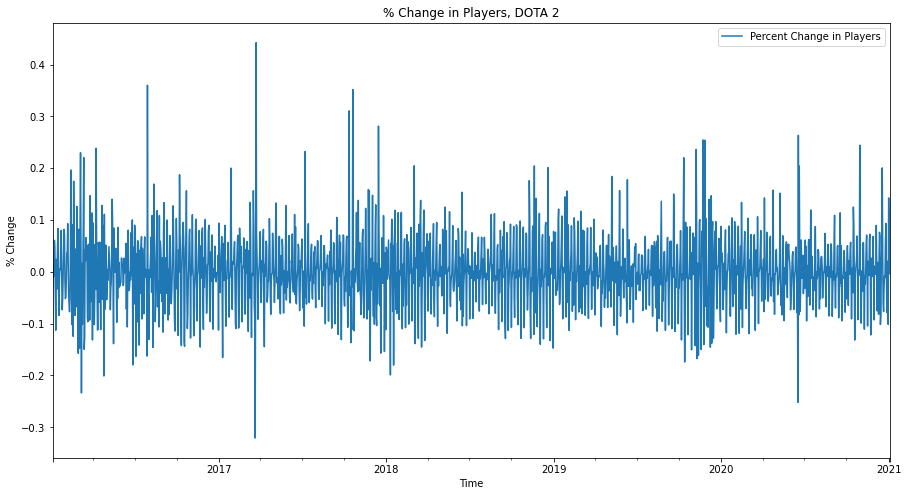

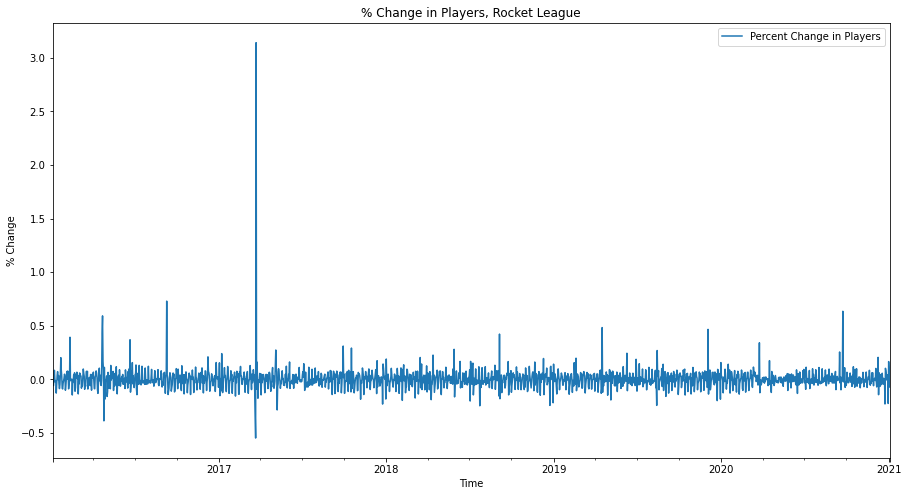

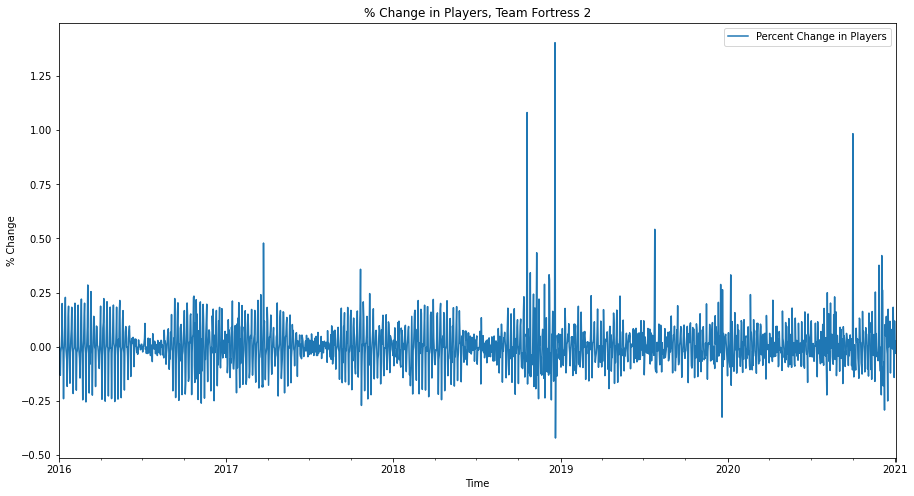

In [42]:
# visualizing this feature
for i, df in enumerate(ls):
    
    df.plot(y = '%chg_players', label = 'Percent Change in Players', figsize = (15,8),
           xlabel = 'Time', ylabel = '% Change', title = "% Change in Players, "+ labels[i])


In [43]:
# we should average our data before removing outliers

average_pc = []

for i in range(len(ls[0])):
    pc = '%chg_players'
    average_at_i = np.array([ls[0][pc][i], ls[1][pc][i], ls[2][pc][i], ls[3][pc][i]]).mean() 
    average_pc.append(average_at_i)

df_model = ls[0].copy()
df_model["mean_%chg_players"] = average_pc
df_model = pd.DataFrame(df_model['mean_%chg_players'])

df_model

mean_%chg_players
DateTime                     
2016-01-04          -0.028664
2016-01-05          -0.014695
2016-01-06          -0.019099
2016-01-07          -0.035620
2016-01-08           0.045607
...                       ...
2020-12-30           0.011848
2020-12-31          -0.053178
2021-01-01           0.082226
2021-01-02           0.016156
2021-01-03           0.008673

[1827 rows x 1 columns]

In [44]:
# checking our stationarity with ADF test


    
df = df_model.dropna()
result = adfuller(df)
print("ADF Test : Mean Model")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('')

ADF Test : Mean Model
ADF Statistic: -9.935198
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



In [45]:
# while our data is already stationary, we have to address outliers, much like we did before with our logged differences. 

outlier_removed = []

IQR = scipy.stats.iqr(df_model)
mean = df_model.mean()
quantiles = df_model["mean_%chg_players"].quantile([0.25, 0.75])
Q1 = quantiles[0.25]
Q3 = quantiles[0.75]
upper = Q3 + 3*IQR
lower = Q1 - 3*IQR
for val in df_model["mean_%chg_players"]:
        if val > upper:
            outlier_removed.append(df_model["mean_%chg_players"][i-1])
        elif val < lower:
            outlier_removed.append(df_model["mean_%chg_players"][i-1])
        else:
            outlier_removed.append(val)
df_model['PCOR'] = outlier_removed

df_model = pd.DataFrame(df_model['PCOR'])

df_model



PCOR
DateTime            
2016-01-04 -0.028664
2016-01-05 -0.014695
2016-01-06 -0.019099
2016-01-07 -0.035620
2016-01-08  0.045607
...              ...
2020-12-30  0.011848
2020-12-31 -0.053178
2021-01-01  0.082226
2021-01-02  0.016156
2021-01-03  0.008673

[1827 rows x 1 columns]

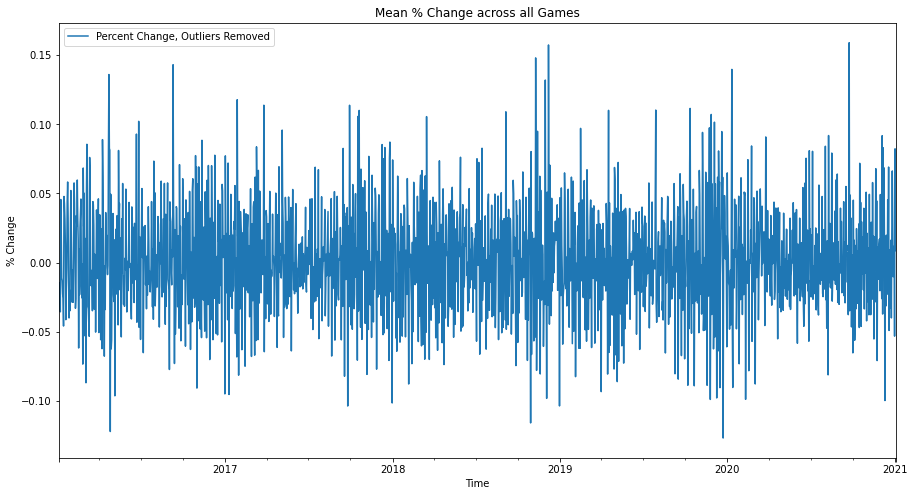

In [46]:
# inspecting how this impacted our visualizations

df_plot = df_model['PCOR']
df_plot.plot(label = "Percent Change, Outliers Removed", figsize = (15, 8),
            xlabel = 'Time', ylabel = '% Change', title = "Mean % Change across all Games")
plt.legend()
plt.show()

Data is ready to be modelled!

As before, we need to first ensure that our seasonality was not affected by our transformations so far. 

### Modelling

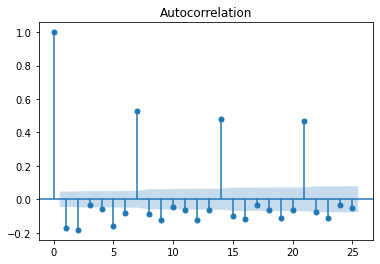

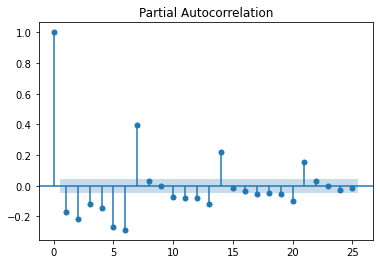

In [47]:
# plotting acf and pacf, showing that our seasonality is retained at s = 7

acf = plot_acf(df_model, lags = 25)
pacf = plot_pacf(df_model, lags = 25)

In [48]:
# defining our parameters for our gridsearch.

p = d = q = range(0, 2)
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]

In [49]:

mods = []
for comb in pdq:
    for combs in pdqs:
        model = SARIMAX(df_model, 
                       order = comb,
                       seasonal_order = combs,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
        output = model.fit()
        mods.append([comb, combs, output.aic])
        print('ARIMA {} X {} : AIC Calculated = {}'.format(comb, combs, round(output.aic, 2)))
models_df = pd.DataFrame(mods, columns = ['pdq', 'pdqs', 'aic'])
best_model = models_df.loc[models_df['aic'].idxmin()].dropna()
    

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6689.68
ARIMA (0, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -7029.68
ARIMA (0, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6784.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -7549.72
ARIMA (0, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7269.79


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -7604.23
ARIMA (0, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -7162.99

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -7555.41
ARIMA (0, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -6772.8


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -7107.7
ARIMA (0, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -6854.53


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7635.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -7347.43


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7690.07


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -7239.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7639.93
ARIMA (0, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5142.37


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -5474.56
ARIMA (0, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -5216.26


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -5987.18
ARIMA (0, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -5707.77


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -6032.9


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -5604.09


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -5995.49


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -6681.83


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -7018.71
ARIMA (0, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -6766.57


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -7529.6


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -7258.58


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -7583.04


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -7148.54


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -7525.46
ARIMA (1, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6737.58


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -7083.08
ARIMA (1, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6843.37


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -7609.08


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7320.66


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -7664.66


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -7216.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -7613.58


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -6871.56


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -7189.16


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -7043.53


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7679.45


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -7415.62


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7730.98


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -7355.79


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7688.69
ARIMA (1, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5652.22


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -6030.2


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -5839.7
ARIMA (1, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -6538.83


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -6292.49


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -6597.84


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -6195.82
ARIMA (1, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -6544.83


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -6733.78


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -7074.9


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -6825.39


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -7588.64


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -7310.81


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -7643.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -7202.33


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -7591.64


In [50]:
print(best_model)

pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic         -7730.98
Name: 45, dtype: object


### Validation

In [51]:
# we generate summary stats for the model

mean_model = SARIMAX(df_model,
             order = best_model.loc['pdq'],
                    seasonal_order = best_model.loc['pdqs'],
             enforce_stationarity = False,
             enforce_invertibility = False)
output = mean_model.fit()
print(output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5683      0.038     14.828      0.000       0.493       0.643
ma.L1         -0.7993      0.029    -27.461      0.000      -0.856      -0.742
ar.S.L7        0.9696      0.007    142.705      0.000       0.956       0.983
ma.S.L7       -0.7778      0.017    -46.354      0.000      -0.811      -0.745
sigma2         0.0008   1.88e-05     43.816      0.000       0.001       0.001


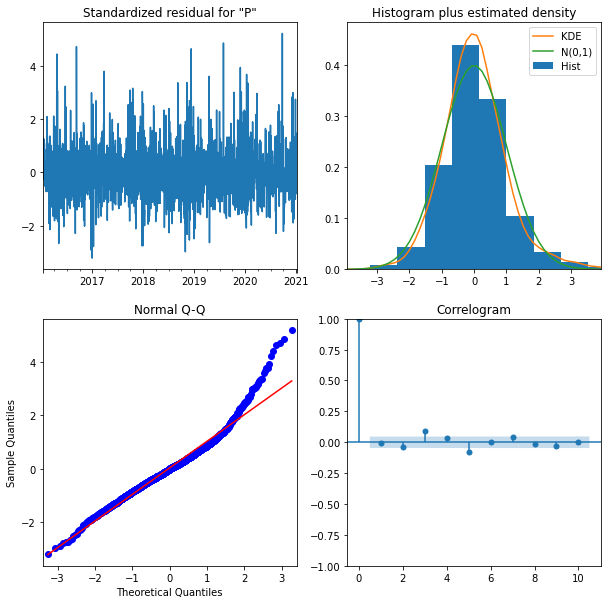

In [52]:
# we visualize validation plots

output.plot_diagnostics(figsize = (10, 10))
plt.show()

#### Forecasting 

We will forecast and calculate the mean squared error for each dataframe, using our constructed model. 

In [53]:
# we generate predictions

pred = output.get_prediction(start = pd.to_datetime("2020-12-15"))
conf_int = pred.conf_int()

forecast = pred.predicted_mean

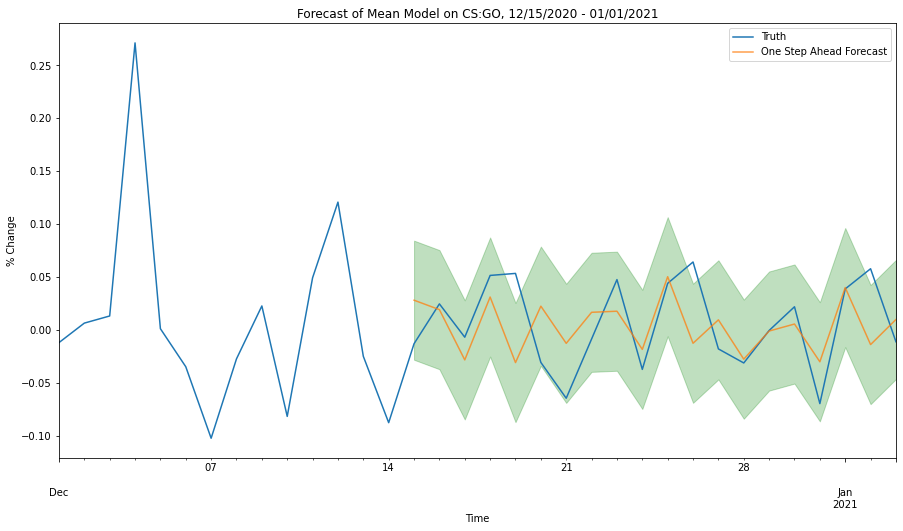

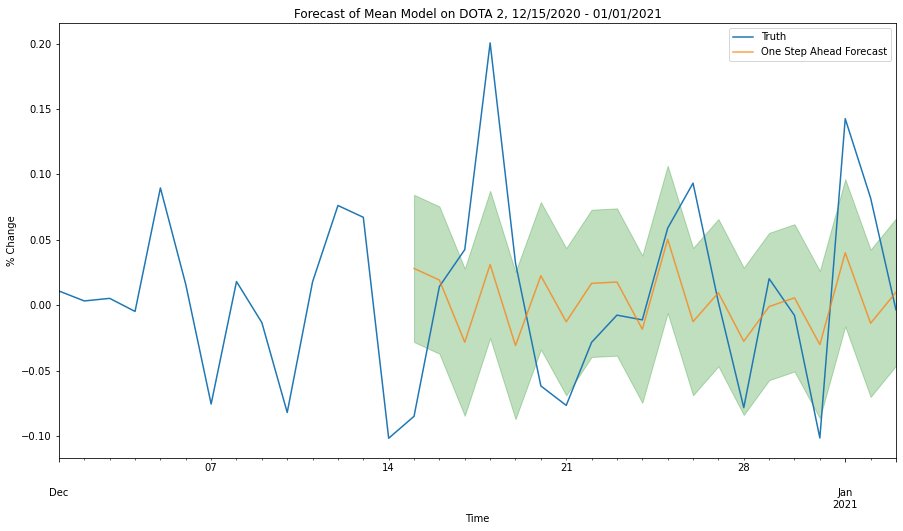

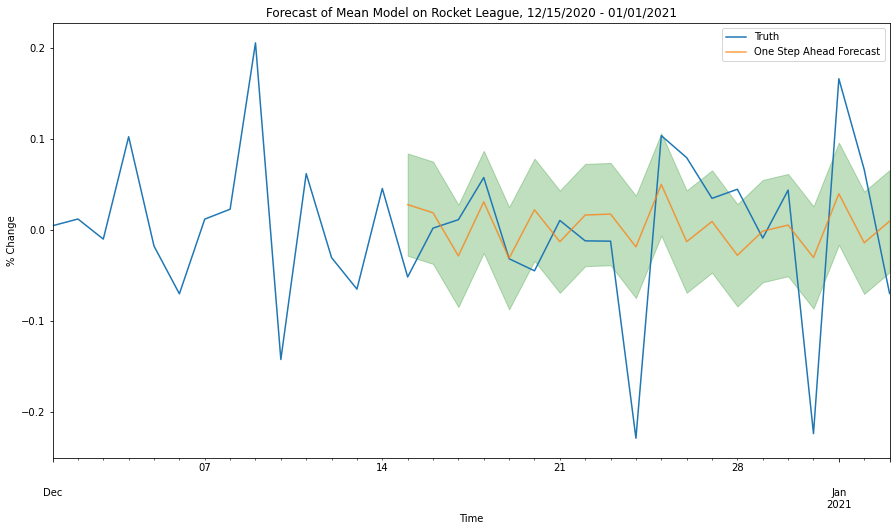

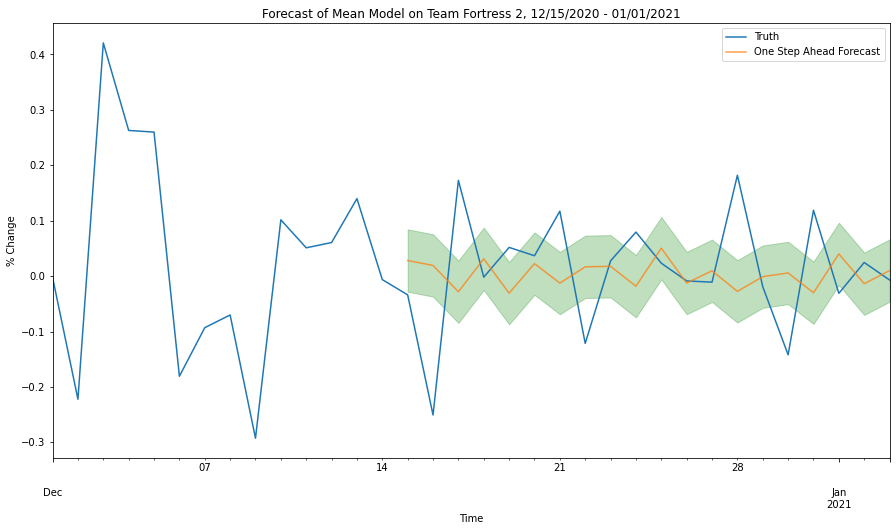

In [54]:
# and visualize the forecasts for each of our dataframes


for i, df in enumerate(ls_w_outliers):
    ax = df['2020-12-01':].plot(y = '%chg_players', label = 'Truth', figsize = (15, 8),
                               xlabel = "Time", ylabel = "% Change",
                               title = 'Forecast of Mean Model on '+labels[i]+', 12/15/2020 - 01/01/2021')
    forecast.plot(ax = ax, label = "One Step Ahead Forecast", alpha = 0.75)
    
    ax.fill_between(conf_int.index,
                   conf_int.iloc[:,0],
                   conf_int.iloc[:,1], color = 'g', alpha = 0.25)
    
    plt.legend()
    plt.show()
    


In [55]:
# finally, we calculate the MSE for each of these forecasts. 

for df in ls_w_outliers:
    forecasted = pred.predicted_mean
    truth = df["2020-12-15":]['%chg_players']
    mse = ((forecasted - truth) ** 2).mean()
    print(mse)

0.0015610172386594876
0.005192905181047031
0.007260650492895336
0.013354021051383152


### Conclusions on Amalgamized Modelling

We constructed one model from the mean change in players for all of our games. This model's summary statistics show that it is more viable than our basic models in part 1, due to the fact that our validation visualizations, namely the QQ plot suggesting that residuals in this model are more normally distributed than for all other models constructed thus far.

This model also has the benefit of being able to be applied to any game. 

In [69]:
# we save all of our constructed models for use in the next notebook

import pickle

models.append(mean_model)

names = ["models/csgo_model.pkl",
"models/dota_model.pkl",
"models/rl_model.pkl",
"models/tf_model.pkl",
"models/mean_model.pkl"]

for i in range(len(models)):
    with open(names[i], 'wb') as file:
        pickle.dump(models[i], file)

In [70]:
# we also save our training and testing dataframes

names = ['csgo_test.csv',
        'dota_test.csv',
        'rl_test.csv',
        'tf_test.csv']

for i in range(len(ls_w_outliers)):
    ls_w_outliers[i].to_csv('data/Test/'+names[i])
    


## Next:

In the next notebook, we will compare our models and describe the pros and cons of each, while also using models to find interesting points in the future. We will also provide our recommendations to those looking to utilize our findings, and conclude with thoughts on how our investigation could have yeilded more insight into these data. 

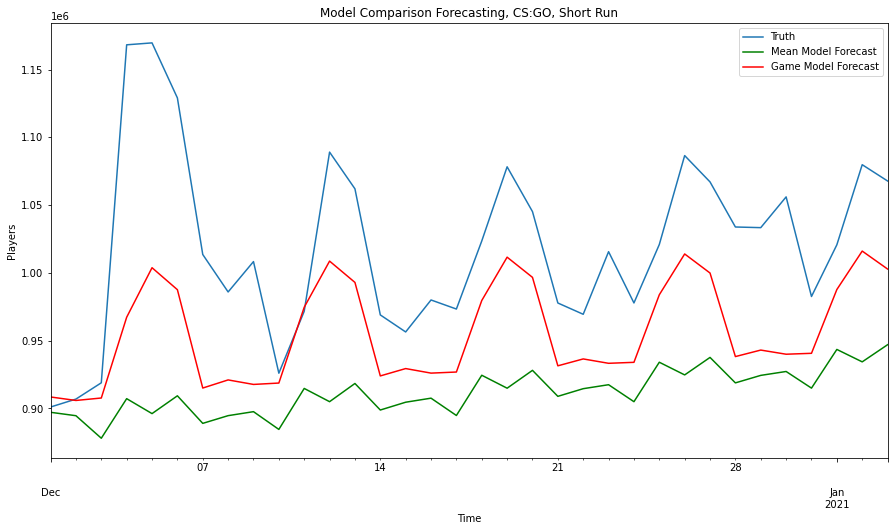

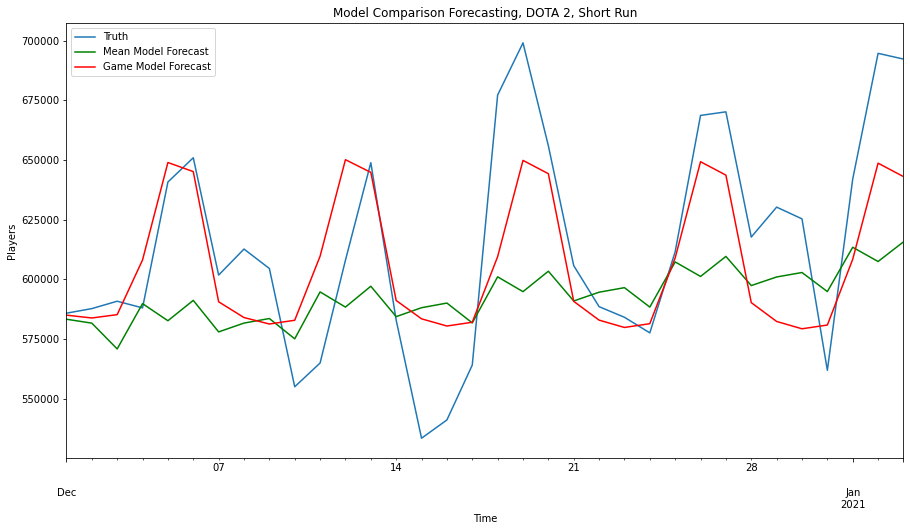

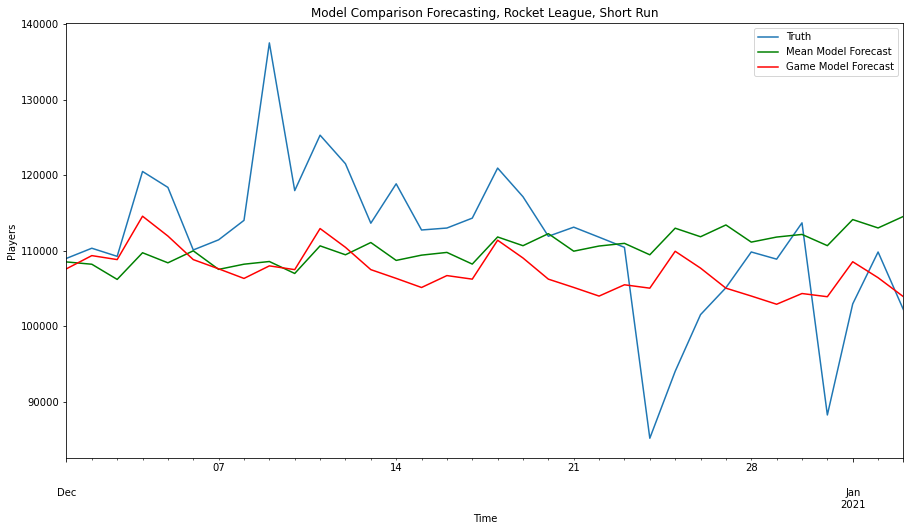

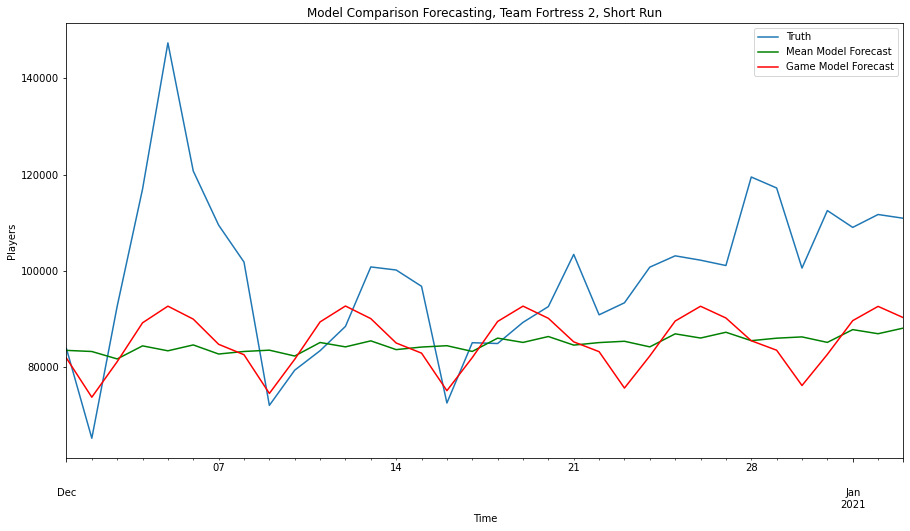

In [58]:
# first address differences, then unlog data

def differenced_logged_data_to_players(forecast, start_time, testing_df):
    logged_player_count = (testing_df['players_logged'][start_time])
    forecast_df = pd.DataFrame(testing_df['players'][start_time:])
    player_count = []
    for diff in (forecast):
        logged_player_count += diff
        players = math.exp(logged_player_count)
        player_count.append(players)
    forecast_df['players'] = player_count
    return forecast_df
        
    
    

def percent_change_data_to_players(forecast, start_time, testing_df, name = 'players'):
    player_count = testing_df['players'][start_time]
    forecast_df = pd.DataFrame(testing_df['players'][start_time:])
    forecast_player_count = []
    for chg in forecast:
        player_count = player_count + (player_count*chg)
        forecast_player_count.append(player_count)
    forecast_df[name] = forecast_player_count
    return forecast_df
        

# SHORT RUN FORECASTING

# we visualize the predictions for each of our games, their own model vs our mean_model

mean_model_mse_vals = []
game_model_mse_vals = []

for i in range(len(ls_w_outliers)):
    
    
    # generating our forecasts and transforming to player counts for both models
    
    mean_output = mean_model.fit()
    mean_pred = mean_output.get_prediction(start = pd.to_datetime("2020-12-01"), dynamic = True, full_results = True)
    mean_forecast = mean_pred.predicted_mean
    mean_forecast_transformed = percent_change_data_to_players(mean_forecast,"2020-12-01", testing_df = ls[i])
    
    game_output = models[i].fit()
    game_pred = game_output.get_prediction(start = pd.to_datetime("2020-12-01"), dynamic = True, full_results = True)
    game_forecast = game_pred.predicted_mean
    game_forecast_transformed = differenced_logged_data_to_players(game_forecast,"2020-12-01", ls[i])
    

    # plotting our data
    
    ax = ls[i]["2020-12-01":].plot(y = 'players', label = 'Truth', figsize = (15, 8),
                                  xlabel = 'Time', ylabel = 'Players',
                                  title = 'Model Comparison Forecasting, '+ labels[i] + ', Short Run')
    ax.plot(mean_forecast_transformed, color = 'green', label = 'Mean Model Forecast')
    ax.plot(game_forecast_transformed, color = 'red', label = 'Game Model Forecast')
    plt.legend()
    plt.show()
    
    
    
    # also calculate mse while we have our forecasts established
    
    truth = ls[i]["2020-12-01":]['players']
    mean_model_mse = ((mean_forecast_transformed['players'] - truth)**2).mean()
    game_model_mse = ((game_forecast_transformed['players'] - truth)**2).mean()
    
    mean_model_mse_vals.append(mean_model_mse)
    game_model_mse_vals.append(game_model_mse)

In [59]:
mse_df = pd.DataFrame()
mse_df['MEAN_MODEL_MSE'] = mean_model_mse_vals
mse_df['GAME_MODEL_MSE'] = game_model_mse_vals
mse_df

MEAN_MODEL_MSE  GAME_MODEL_MSE
0    1.526227e+10    5.971194e+09
1    1.904218e+09    9.047395e+08
2    1.126553e+08    9.534872e+07
3    4.448534e+08    3.811079e+08

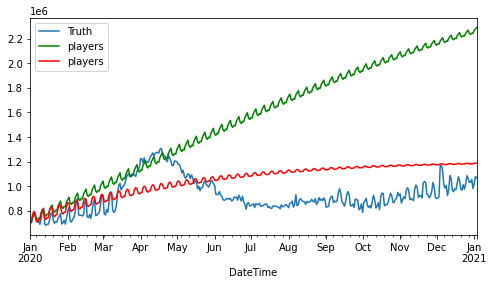

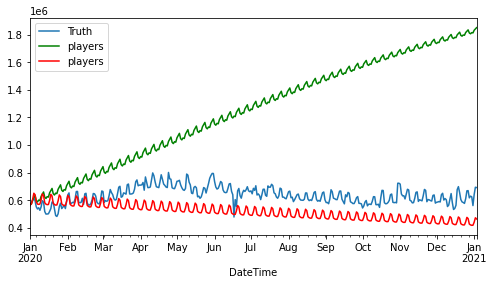

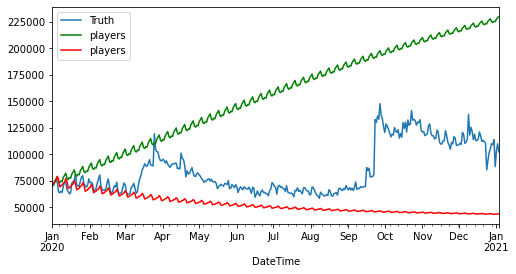

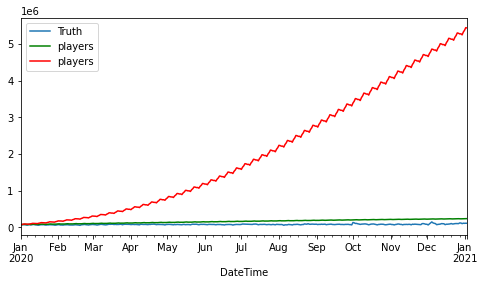

In [63]:
# LONG RUN FORECASTING

# we visualize the predictions for each of our games, their own model vs our mean_model

mean_model_mse_vals = []
game_model_mse_vals = []

for i in range(len(ls_w_outliers)):
    ax = plt.subplots(figsize = (8, 4))
    
    ax = ls_w_outliers[i]["2020-01-01":]['players'].plot(label = 'Truth')
    
    mean_pred = mean_output.get_prediction(start = pd.to_datetime("2020-01-01"), dynamic = True, full_results = True)
    mean_forecast = mean_pred.predicted_mean
    mean_forecast_transformed = percent_change_data_to_players(mean_forecast,"2020-01-01", testing_df = ls_w_outliers[i])
    
    game_output = models[i].fit()
    game_pred = game_output.get_prediction(start = pd.to_datetime("2020-01-01"), dynamic = True, full_results = True)
    game_forecast = game_pred.predicted_mean
    game_forecast_transformed = differenced_logged_data_to_players(game_forecast,"2020-01-01", ls[i])
    
    mean_forecast_transformed.plot(ax = ax, color = 'green', label = 'Mean Model Forecast')
    game_forecast_transformed.plot(ax = ax, color = 'red', label = 'Game Model Forecast')
    plt.legend()
    plt.show()
    
    
    # also calculate mse while we have our forecasts established
    truth = ls[i]["2020-01-01":]['players']
    mean_model_mse = ((mean_forecast_transformed['players'] - truth)**2).mean()
    game_model_mse = ((game_forecast_transformed['players'] - truth)**2).mean()
    
    mean_model_mse_vals.append(mean_model_mse)
    game_model_mse_vals.append(game_model_mse)